In [101]:
import pandas as pd
import os
import pyodbc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [102]:
os.chdir(r"C:\Users\Margarida\OneDrive - Universidade de Coimbra\GitHub\eRedes_seminario\dados")

In [103]:
cons_horario_raw = pd.read_csv('consumoshorariocodigopostal2821a3080.csv', sep=';')

In [104]:
cons_horario_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4211342 entries, 0 to 4211341
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Data/Hora                object 
 1   Código Postal            object 
 2   Energia ativa (kWh)      float64
 3   Data                     object 
 4   Hora                     object 
 5   Código Postal 4 Dígitos  int64  
 6   Código Postal 3 Dígitos  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 224.9+ MB


In [105]:
# Filtrar o DataFrame para entradas com código postal de 4 dígitos entre 3000 e 3060
df_3000 = cons_horario_raw[(cons_horario_raw['Código Postal 4 Dígitos'] >= 3000) & (cons_horario_raw['Código Postal 4 Dígitos'] <= 3060)]

# Verificar as primeiras entradas do DataFrame filtrado
df_3000.head()

Data/Hora Código Postal  Energia ativa (kWh)        Data  \
2  2024-02-11T21:00:00+00:00      3000-442            37.200000  2024-02-11   
5  2024-02-13T19:00:00+00:00      3045-031            19.344000  2024-02-13   
7  2024-02-15T04:00:00+00:00      3020-928           158.598188  2024-02-15   
8  2024-02-15T07:00:00+00:00      3050-019            35.708000  2024-02-15   
9  2024-02-15T08:00:00+00:00      3030-182           158.569659  2024-02-15   

    Hora  Código Postal 4 Dígitos  Código Postal 3 Dígitos  
2  21:00                     3000                      442  
5  19:00                     3045                       31  
7  04:00                     3020                      928  
8  07:00                     3050                       19  
9  08:00                     3030                      182

In [106]:
# Garantir que a coluna de tempo está no formato datetime
df_3000['Data/Hora'] = pd.to_datetime(df_3000['Data/Hora'])

# Extrair data e ordenar
df_3000['Dia'] = df_3000['Data/Hora'].dt.date
df_3000.sort_values(['Código Postal', 'Data/Hora'], inplace=True)

# Calcular os intervalos entre registos (por código postal e dia)
df_3000['delta_min'] = df_3000.groupby(['Código Postal', 'Dia'])['Data/Hora'].diff().dt.total_seconds() / 60

# Resumo estatístico por código postal e dia
resumo = df_3000.groupby(['Código Postal', 'Dia']).agg(
    n_registos=('Data/Hora', 'count'),
    consumo_total=('Energia ativa (kWh)', 'sum'),
    intervalo_médio_min=('delta_min', 'mean'),
    intervalo_mínimo_min=('delta_min', 'min'),
    intervalo_máximo_min=('delta_min', 'max'),
    tempo_coberto_horas=('Data/Hora', lambda x: (x.max() - x.min()).total_seconds() / 3600)
).reset_index()

print(resumo.head())

C:\Users\Margarida\AppData\Local\Temp\ipykernel_30844\3442392533.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3000['Data/Hora'] = pd.to_datetime(df_3000['Data/Hora'])
C:\Users\Margarida\AppData\Local\Temp\ipykernel_30844\3442392533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3000['Dia'] = df_3000['Data/Hora'].dt.date
C:\Users\Margarida\AppData\Local\Temp\ipykernel_30844\3442392533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

  Código Postal         Dia  n_registos  consumo_total  intervalo_médio_min  \
0      3000-003  2024-02-01          24     868.093443                 60.0   
1      3000-003  2024-02-02          24     871.732848                 60.0   
2      3000-003  2024-02-03          24     808.850274                 60.0   
3      3000-003  2024-02-04          24     874.886899                 60.0   
4      3000-003  2024-02-05          24     921.983030                 60.0   

   intervalo_mínimo_min  intervalo_máximo_min  tempo_coberto_horas  
0                  60.0                  60.0                 23.0  
1                  60.0                  60.0                 23.0  
2                  60.0                  60.0                 23.0  
3                  60.0                  60.0                 23.0  
4                  60.0                  60.0                 23.0  


## ESTATÍSTICAS DESCRITIVAS

### NÃO NORMALIZADO

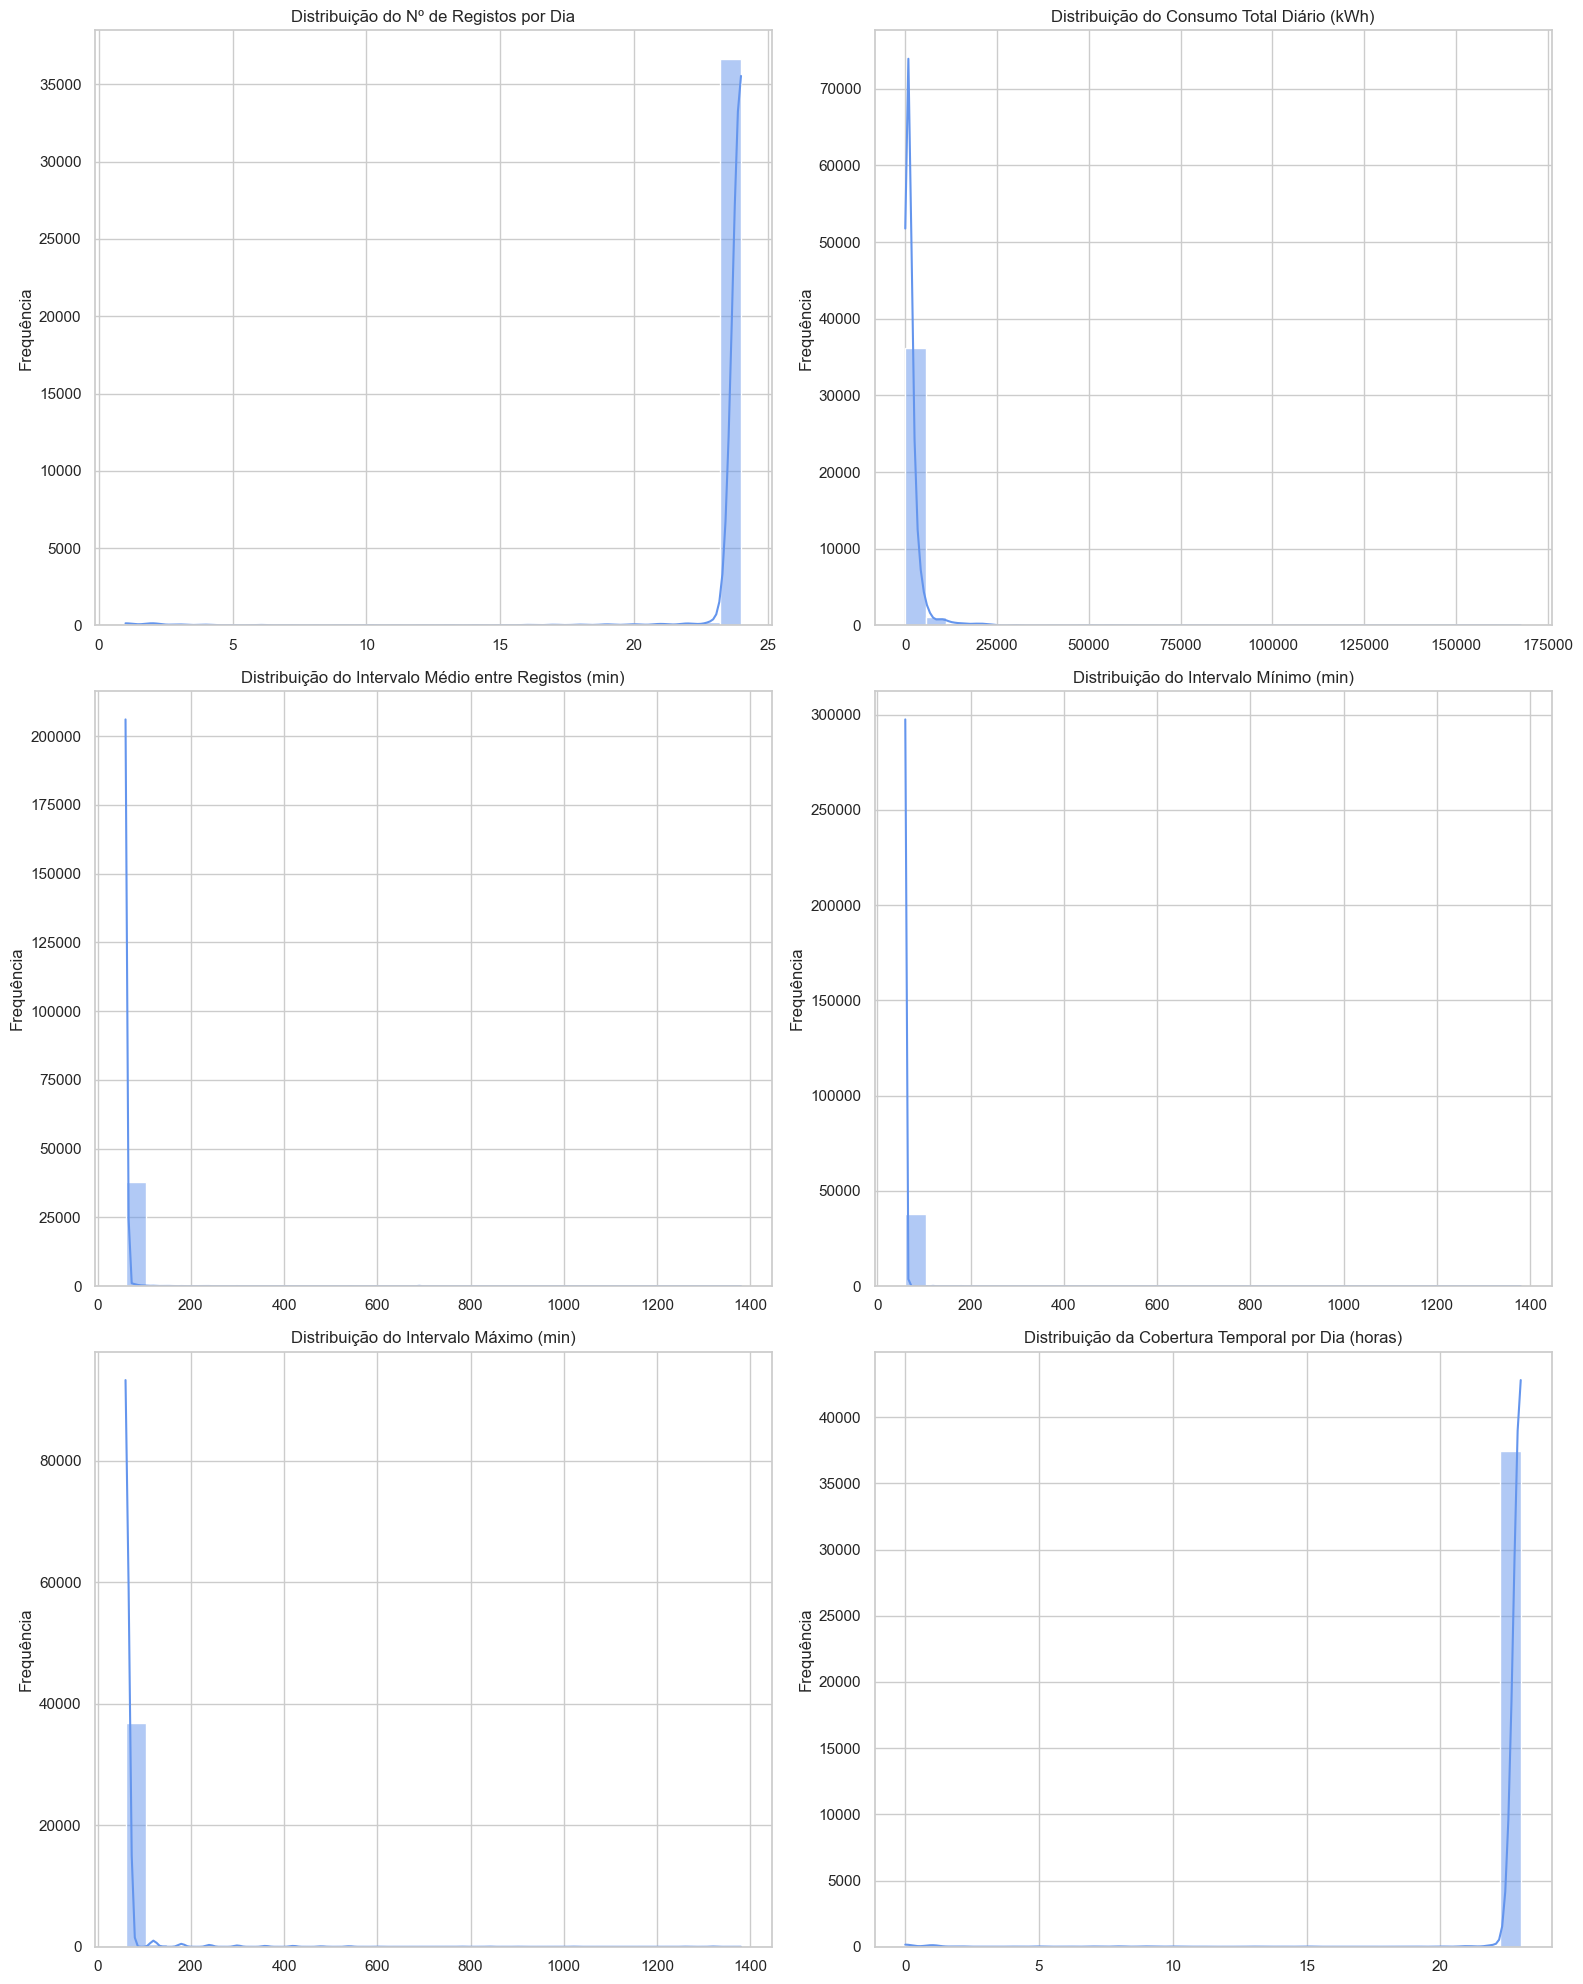

In [107]:
sns.set(style="whitegrid")

# Lista de métricas a visualizar
metricas = [
    'n_registos',
    'consumo_total',
    'intervalo_médio_min',
    'intervalo_mínimo_min',
    'intervalo_máximo_min',
    'tempo_coberto_horas'
]

# Títulos para os gráficos
titulos = {
    'n_registos': 'Distribuição do Nº de Registos por Dia',
    'consumo_total': 'Distribuição do Consumo Total Diário (kWh)',
    'intervalo_médio_min': 'Distribuição do Intervalo Médio entre Registos (min)',
    'intervalo_mínimo_min': 'Distribuição do Intervalo Mínimo (min)',
    'intervalo_máximo_min': 'Distribuição do Intervalo Máximo (min)',
    'tempo_coberto_horas': 'Distribuição da Cobertura Temporal por Dia (horas)'
}

# Tamanho da figura
plt.figure(figsize=(16, 20))

# Criar subplots para cada métrica
for i, metrica in enumerate(metricas, 1):
    plt.subplot(3, 2, i)
    sns.histplot(resumo[metrica], bins=30, kde=True, color='cornflowerblue')
    plt.title(titulos[metrica])
    plt.xlabel('')
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

### NORMALIZADO

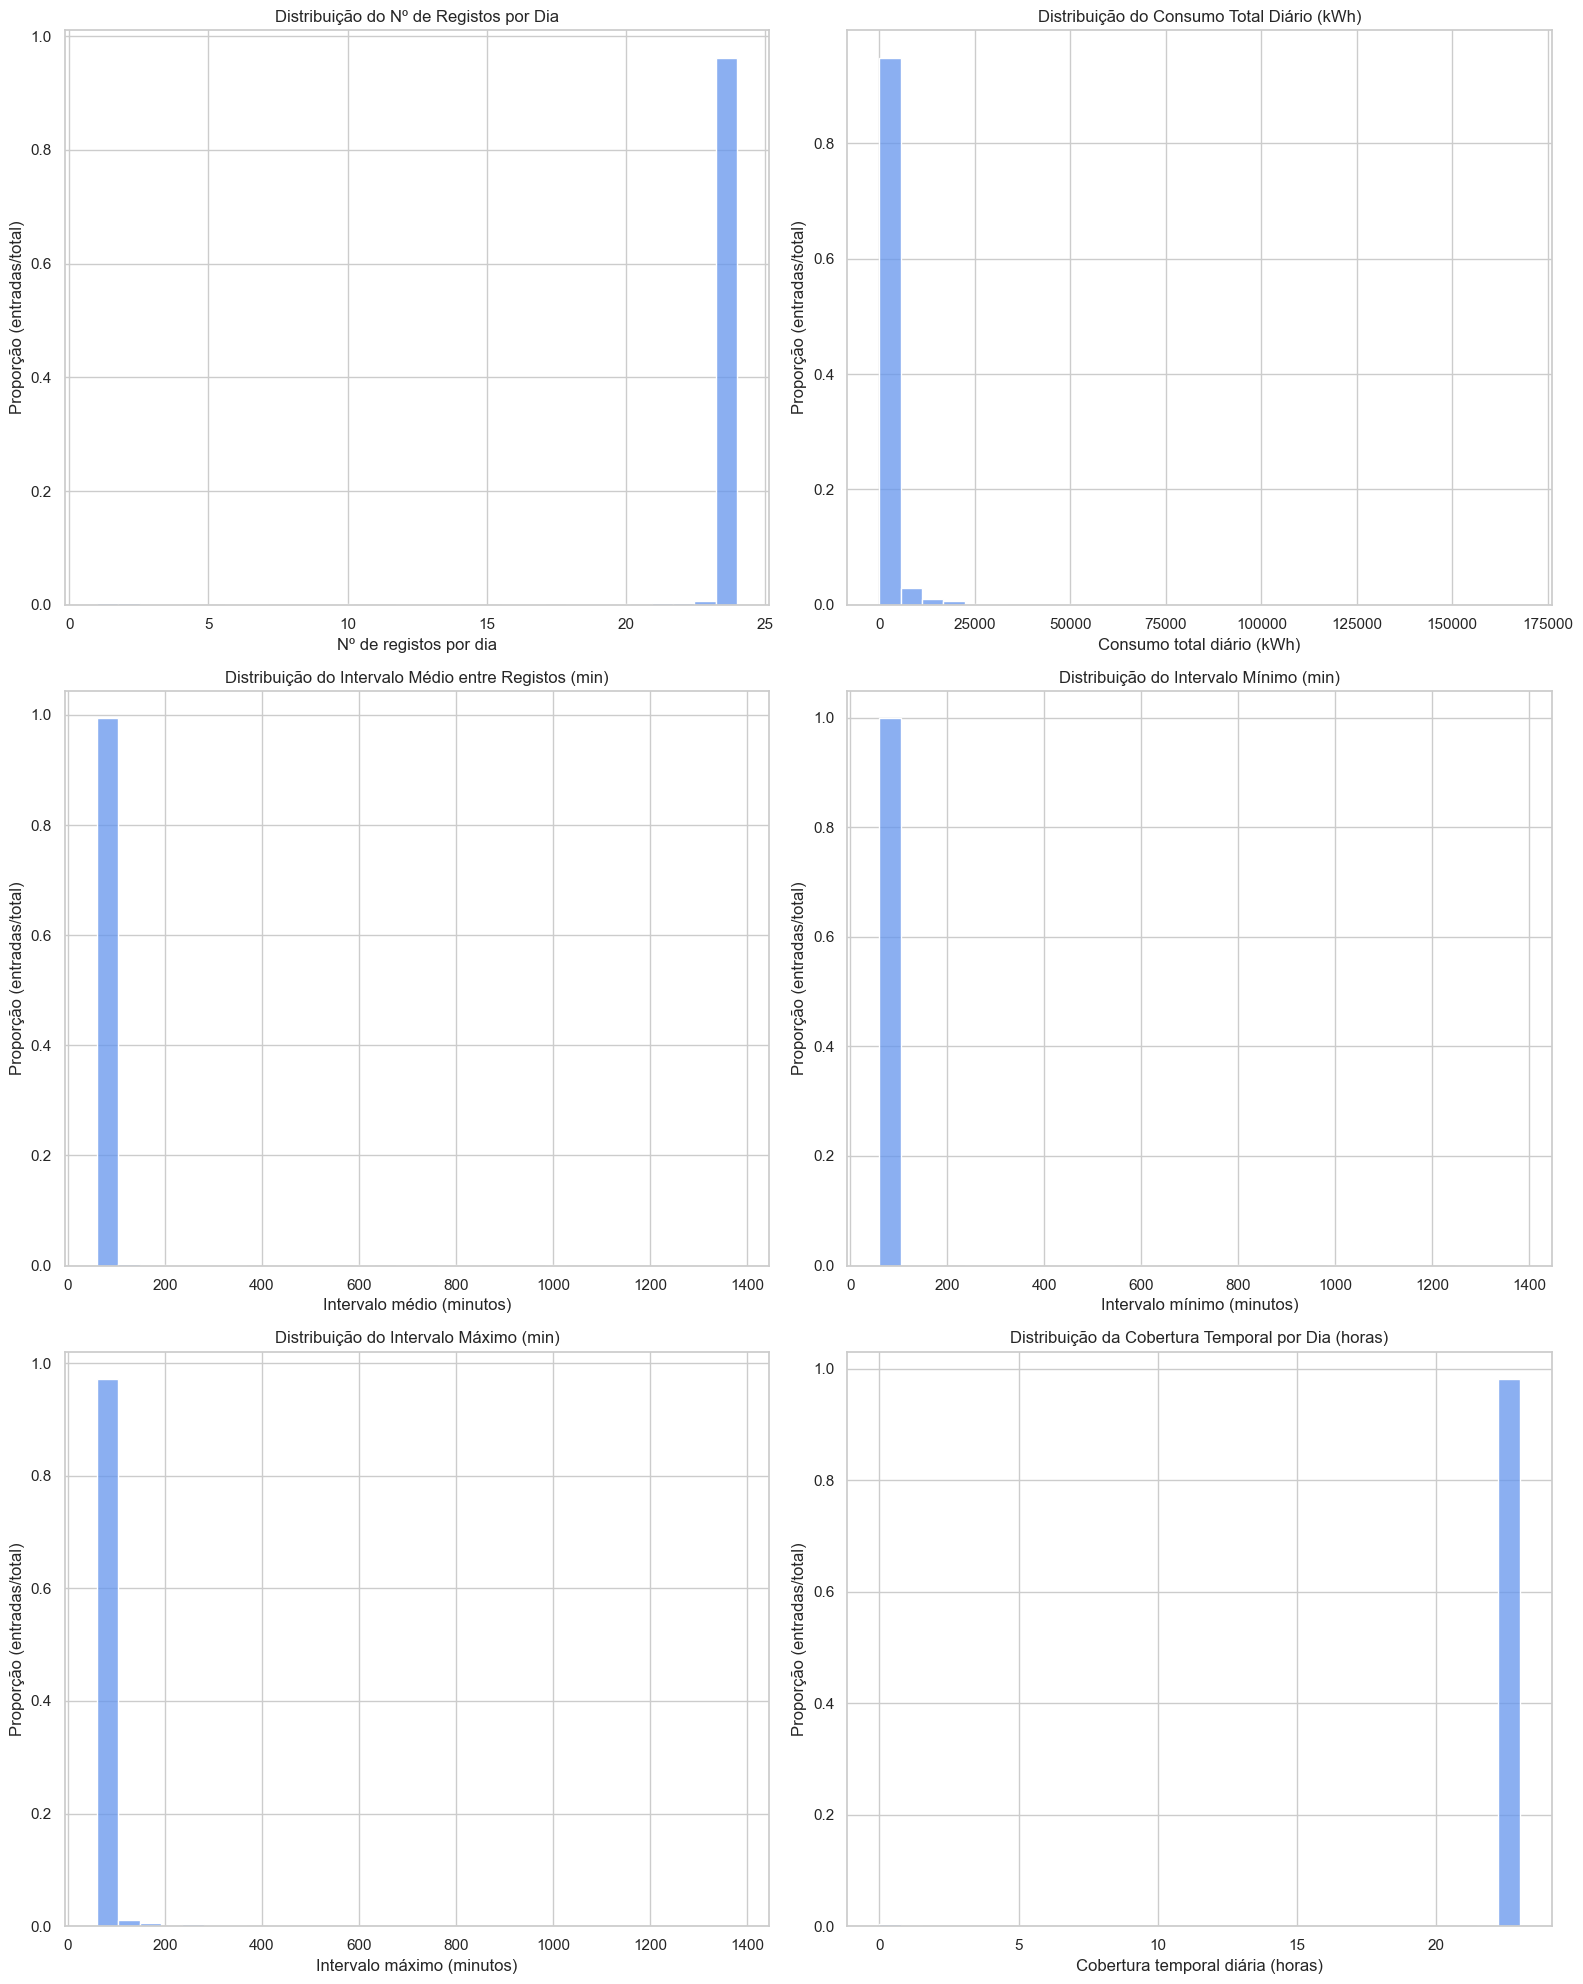

In [108]:

sns.set(style="whitegrid")

metricas = [
    'n_registos',
    'consumo_total',
    'intervalo_médio_min',
    'intervalo_mínimo_min',
    'intervalo_máximo_min',
    'tempo_coberto_horas'
]

titulos = {
    'n_registos': 'Distribuição do Nº de Registos por Dia',
    'consumo_total': 'Distribuição do Consumo Total Diário (kWh)',
    'intervalo_médio_min': 'Distribuição do Intervalo Médio entre Registos (min)',
    'intervalo_mínimo_min': 'Distribuição do Intervalo Mínimo (min)',
    'intervalo_máximo_min': 'Distribuição do Intervalo Máximo (min)',
    'tempo_coberto_horas': 'Distribuição da Cobertura Temporal por Dia (horas)'
}

labels_x = {
    'n_registos': 'Nº de registos por dia',
    'consumo_total': 'Consumo total diário (kWh)',
    'intervalo_médio_min': 'Intervalo médio (minutos)',
    'intervalo_mínimo_min': 'Intervalo mínimo (minutos)',
    'intervalo_máximo_min': 'Intervalo máximo (minutos)',
    'tempo_coberto_horas': 'Cobertura temporal diária (horas)'
}

plt.figure(figsize=(16, 20))

for i, metrica in enumerate(metricas, 1):
    plt.subplot(3, 2, i)
    
    # Obtem valores e normaliza para proporções
    dados = resumo[metrica].dropna()
    total = len(dados)
    sns.histplot(dados, bins=30, stat="probability", kde=False, color='cornflowerblue')
    
    plt.title(titulos[metrica])
    plt.xlabel(labels_x[metrica])
    plt.ylabel('Proporção (entradas/total)')

plt.tight_layout()
plt.show()


## RESUMO EM TABELA, COM MEDIDAS DE TENDÊNCIA CENTRAL, QUARTIS, ETC.

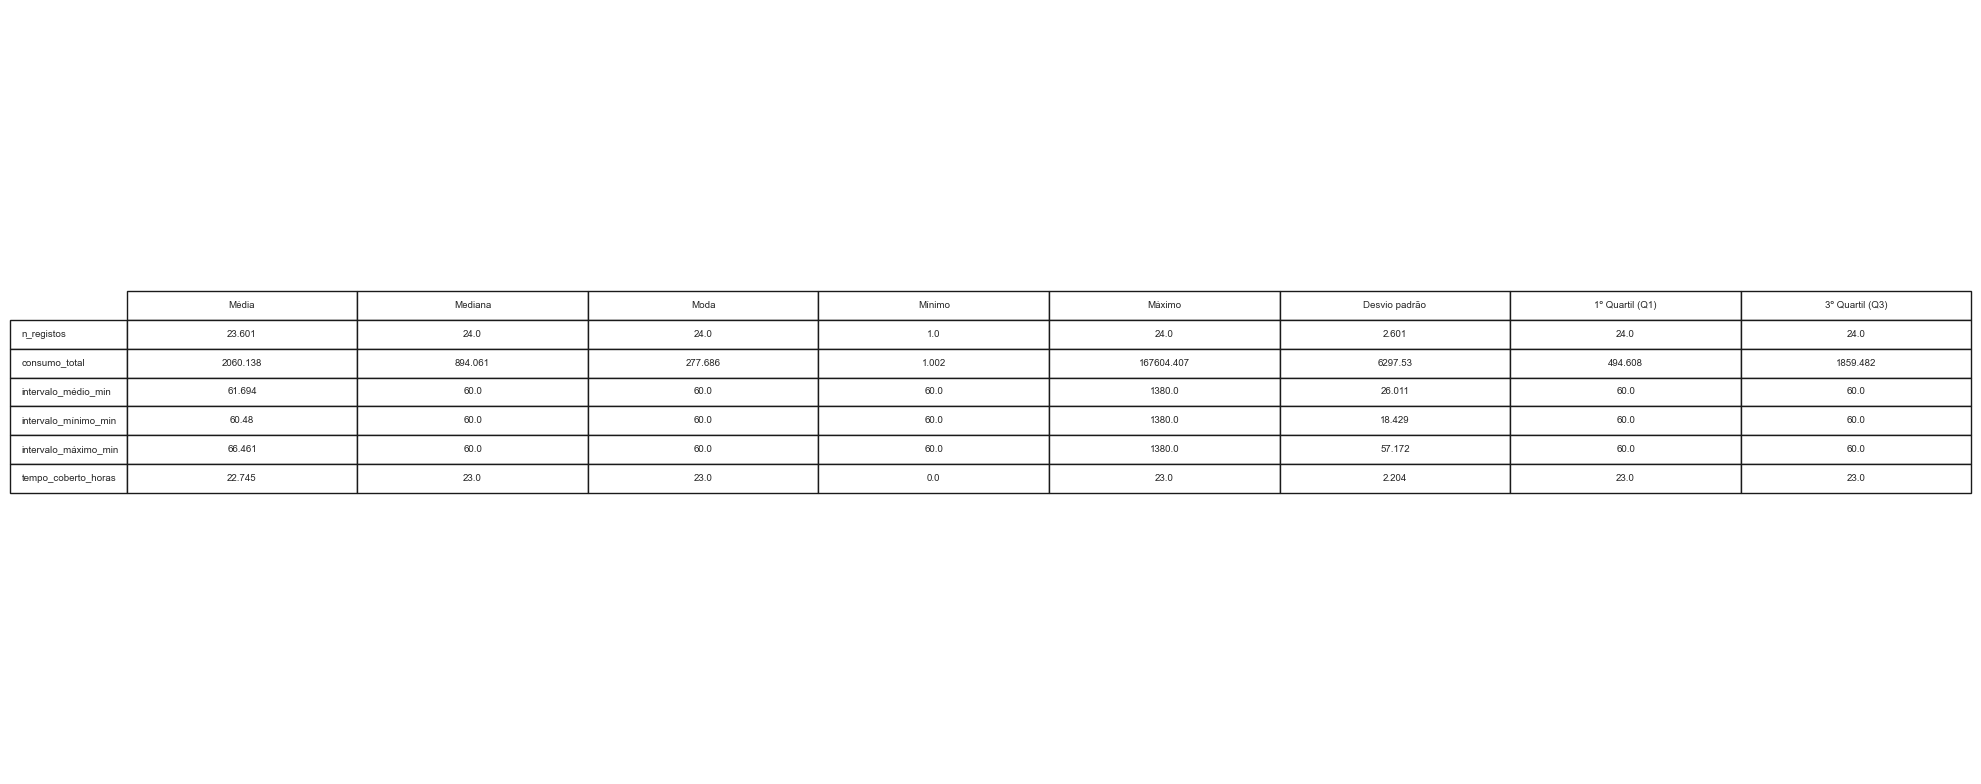

In [109]:
from scipy.stats import mode

# Métricas a analisar
metricas = [
    'n_registos',
    'consumo_total',
    'intervalo_médio_min',
    'intervalo_mínimo_min',
    'intervalo_máximo_min',
    'tempo_coberto_horas'
]

# Tabela descritiva
estatisticas = {}

for metrica in metricas:
    serie = resumo[metrica].dropna()

    moda_val, moda_count = mode(serie, keepdims=True)

    estatisticas[metrica] = {
        'Média': serie.mean(),
        'Mediana': serie.median(),
        'Moda': moda_val[0] if len(moda_val) > 0 else np.nan,
        'Mínimo': serie.min(),
        'Máximo': serie.max(),
        'Desvio padrão': serie.std(),
        '1º Quartil (Q1)': serie.quantile(0.25),
        '3º Quartil (Q3)': serie.quantile(0.75),
    }

# Criar DataFrame final
df_estatisticas = pd.DataFrame(estatisticas).T.round(3)

# Criar imagem da tabela
fig, ax = plt.subplots(figsize=(20, 8))
ax.axis('off')
tbl = ax.table(
    cellText=df_estatisticas.values,
    colLabels=df_estatisticas.columns,
    rowLabels=df_estatisticas.index,
    cellLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(7)
tbl.scale(1.2, 1.4)

plt.tight_layout()
plt.show()

In [110]:
# Garantir que a coluna 'Data' está em formato datetime
df_3000['Data'] = pd.to_datetime(df_3000['Data'])

# Agrupar por código postal e data, contando o número de registos por dia
registos_por_dia = df_3000.groupby(['Código Postal', df_3000['Data'].dt.date]).size()

# Verificar quantos códigos postais têm menos de 23 registos por dia
cp_com_menos_23_registos = registos_por_dia.groupby('Código Postal').apply(lambda x: (x < 23).sum())

# Contar o número de códigos postais que têm pelo menos um dia com menos de 23 registos
num_cp_com_menos_23 = (cp_com_menos_23_registos > 0).sum()

proporcao_menos_23 = (cp_com_menos_23_registos > 0).sum() / len(cp_com_menos_23_registos)

print(f"Proporção de códigos postais que não têm 23 ou mais registos por dia: {proporcao_menos_23:.2f}")

print(f"Número de códigos postais que não têm 23 ou mais registos por dia: {num_cp_com_menos_23}")


C:\Users\Margarida\AppData\Local\Temp\ipykernel_30844\620884910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3000['Data'] = pd.to_datetime(df_3000['Data'])


Proporção de códigos postais que não têm 23 ou mais registos por dia: 0.14
Número de códigos postais que não têm 23 ou mais registos por dia: 194


## NOVO DF, SÓ COM OS CODIGOS POSTAIS COM < 23 ENTRADAS POR DIA

In [111]:
# Filtrar os códigos postais que têm menos de 23 registos por dia
cp_com_menos_23_registos = registos_por_dia.groupby('Código Postal').apply(lambda x: (x < 23).sum())

# Obter os códigos postais que têm pelo menos um dia com menos de 23 registos
cp_com_menos_23 = cp_com_menos_23_registos[cp_com_menos_23_registos > 0].index

# Filtrar o dataset original para incluir apenas os códigos postais com menos de 23 registos por dia
df_menos_23_registos = df_3000[df_3000['Código Postal'].isin(cp_com_menos_23)].copy()

# Verificar as primeiras linhas do novo dataset
print(df_menos_23_registos.head())

                        Data/Hora Código Postal  Energia ativa (kWh)  \
2629069 2024-02-07 01:00:00+00:00      3000-010               10.840   
4025087 2024-02-07 02:00:00+00:00      3000-010               15.786   
7293    2024-02-07 03:00:00+00:00      3000-010               10.032   
722930  2024-02-07 04:00:00+00:00      3000-010               14.702   
1436195 2024-02-07 05:00:00+00:00      3000-010               11.748   

              Data   Hora  Código Postal 4 Dígitos  Código Postal 3 Dígitos  \
2629069 2024-02-07  01:00                     3000                       10   
4025087 2024-02-07  02:00                     3000                       10   
7293    2024-02-07  03:00                     3000                       10   
722930  2024-02-07  04:00                     3000                       10   
1436195 2024-02-07  05:00                     3000                       10   

                Dia  delta_min  
2629069  2024-02-07        NaN  
4025087  2024-02-07       

In [112]:
# Garantir que a coluna de tempo está no formato datetime
df_menos_23_registos['Data/Hora'] = pd.to_datetime(df_menos_23_registos['Data/Hora'])

# Extrair data e ordenar
df_menos_23_registos['Dia'] = df_menos_23_registos['Data/Hora'].dt.date
df_menos_23_registos.sort_values(['Código Postal', 'Data/Hora'], inplace=True)

# Calcular os intervalos entre registos (por código postal e dia)
df_menos_23_registos['delta_min'] = df_menos_23_registos.groupby(['Código Postal', 'Dia'])['Data/Hora'].diff().dt.total_seconds() / 60

# Resumo estatístico por código postal e dia
resumo_menosde23 = df_menos_23_registos.groupby(['Código Postal', 'Dia']).agg(
    n_registos=('Data/Hora', 'count'),
    consumo_total=('Energia ativa (kWh)', 'sum'),
    intervalo_médio_min=('delta_min', 'mean'),
    intervalo_mínimo_min=('delta_min', 'min'),
    intervalo_máximo_min=('delta_min', 'max'),
    tempo_coberto_horas=('Data/Hora', lambda x: (x.max() - x.min()).total_seconds() / 3600)
).reset_index()

print(resumo_menosde23.head())

  Código Postal         Dia  n_registos  consumo_total  intervalo_médio_min  \
0      3000-010  2024-02-07          23        787.420                 60.0   
1      3000-010  2024-02-08          21        587.706                 60.0   
2      3000-010  2024-02-09           8        156.514                 60.0   
3      3000-010  2024-02-10          24        777.964                 60.0   
4      3000-010  2024-02-11          24        676.980                 60.0   

   intervalo_mínimo_min  intervalo_máximo_min  tempo_coberto_horas  
0                  60.0                  60.0                 22.0  
1                  60.0                  60.0                 20.0  
2                  60.0                  60.0                  7.0  
3                  60.0                  60.0                 23.0  
4                  60.0                  60.0                 23.0  


### ESTATÍSTICAS DESCRITIVAS DO SUBCONJUNTO IMPERFEITO

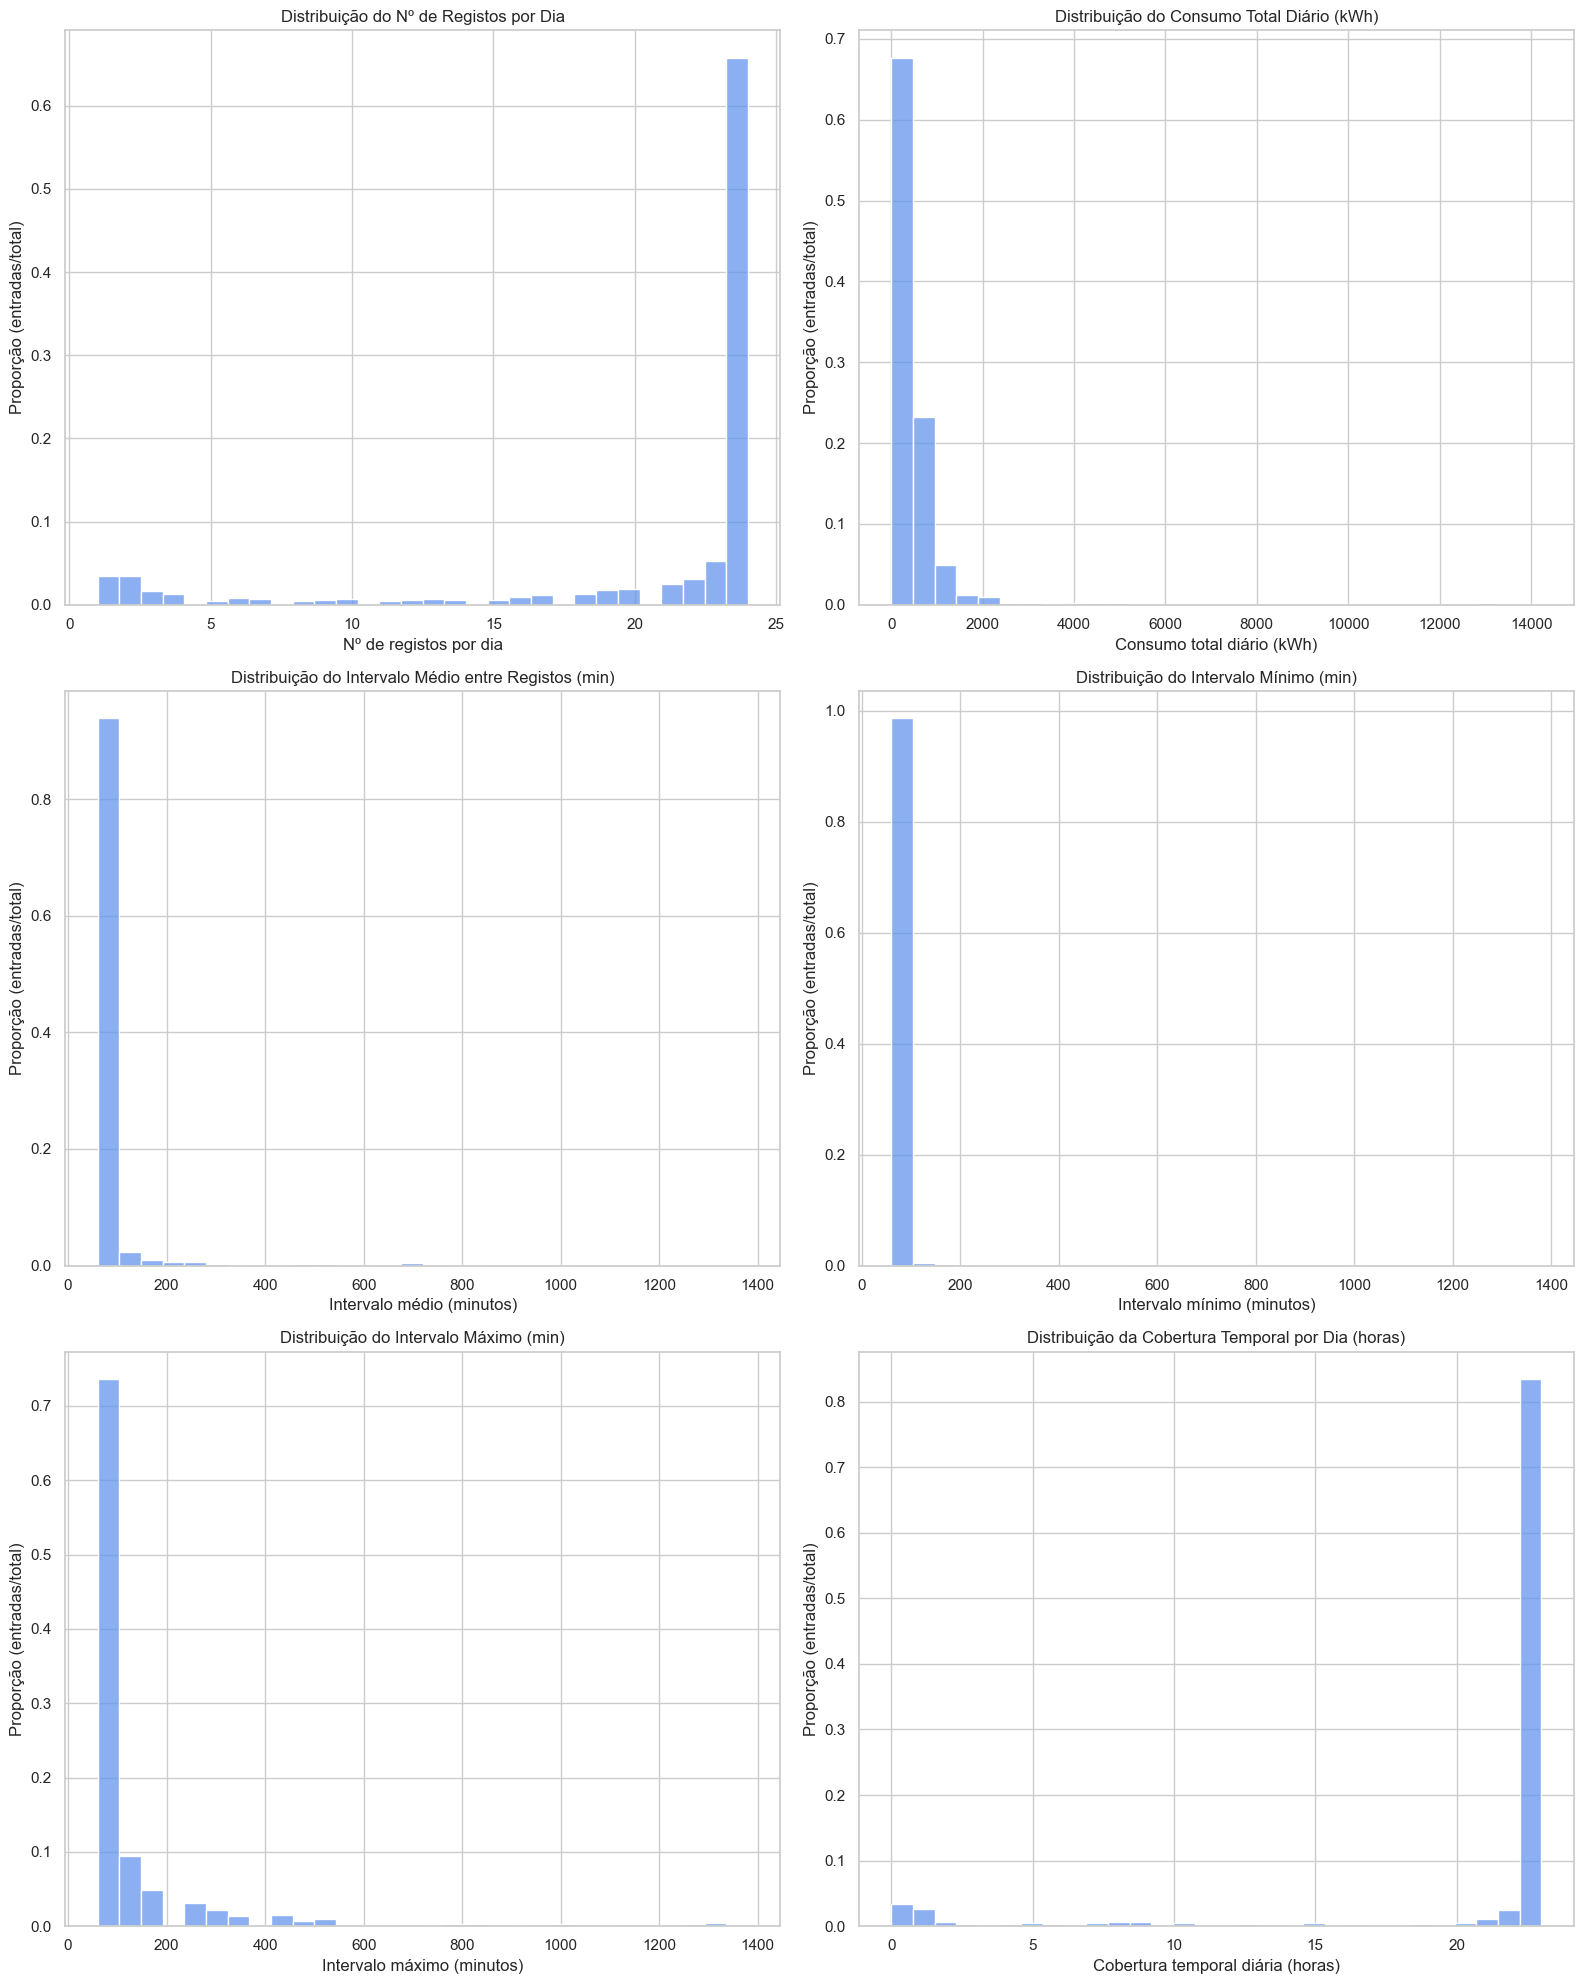

In [113]:

sns.set(style="whitegrid")

metricas23 = [
    'n_registos',
    'consumo_total',
    'intervalo_médio_min',
    'intervalo_mínimo_min',
    'intervalo_máximo_min',
    'tempo_coberto_horas'
]

titulos23 = {
    'n_registos': 'Distribuição do Nº de Registos por Dia',
    'consumo_total': 'Distribuição do Consumo Total Diário (kWh)',
    'intervalo_médio_min': 'Distribuição do Intervalo Médio entre Registos (min)',
    'intervalo_mínimo_min': 'Distribuição do Intervalo Mínimo (min)',
    'intervalo_máximo_min': 'Distribuição do Intervalo Máximo (min)',
    'tempo_coberto_horas': 'Distribuição da Cobertura Temporal por Dia (horas)'
}

labels_x23 = {
    'n_registos': 'Nº de registos por dia',
    'consumo_total': 'Consumo total diário (kWh)',
    'intervalo_médio_min': 'Intervalo médio (minutos)',
    'intervalo_mínimo_min': 'Intervalo mínimo (minutos)',
    'intervalo_máximo_min': 'Intervalo máximo (minutos)',
    'tempo_coberto_horas': 'Cobertura temporal diária (horas)'
}

plt.figure(figsize=(16, 20))

for i, metrica in enumerate(metricas23, 1):
    plt.subplot(3, 2, i)
    
    # Obtem valores e normaliza para proporções
    dados = resumo_menosde23[metrica].dropna()
    total = len(dados)
    sns.histplot(dados, bins=30, stat="probability", kde=False, color='cornflowerblue')
    
    plt.title(titulos[metrica])
    plt.xlabel(labels_x[metrica])
    plt.ylabel('Proporção (entradas/total)')

plt.tight_layout()
plt.show()

## VOLTANDO AOS CODIGOS POSTAIS 'PERFEITOS'. ESTATÍSTICA DOS CONSUMOS

In [114]:
# Contar quantos registos existem por dia e por código postal
registos_por_dia = df_3000.groupby(['Código Postal', 'Data']).size()

# Filtrar os códigos postais com pelo menos um dia com mais de 23 registos
cp_com_mais_23_registos = registos_por_dia.groupby('Código Postal').apply(lambda x: (x > 23).sum())
cp_com_mais_23 = cp_com_mais_23_registos[cp_com_mais_23_registos > 0].index

# Filtrar o dataset original
df_mais_23_registos = df_3000[df_3000['Código Postal'].isin(cp_com_mais_23)].copy()

# Criar a pasta se não existir
os.makedirs('resultados_consumo7dig', exist_ok=True)

# Guardar em CSV
df_mais_23_registos.to_csv('resultados_consumo7dig/cons_filtrado7dig.csv', index=False)

In [115]:
df_mais_23_registos.head()

Data/Hora Código Postal  Energia ativa (kWh)  \
2566881 2024-02-01 00:00:00+00:00      3000-003            32.061177   
272789  2024-02-01 01:00:00+00:00      3000-003            26.345827   
3639286 2024-02-01 02:00:00+00:00      3000-003            24.484873   
708798  2024-02-01 03:00:00+00:00      3000-003            22.702250   
441615  2024-02-01 04:00:00+00:00      3000-003            20.844550   

              Data   Hora  Código Postal 4 Dígitos  Código Postal 3 Dígitos  \
2566881 2024-02-01  00:00                     3000                        3   
272789  2024-02-01  01:00                     3000                        3   
3639286 2024-02-01  02:00                     3000                        3   
708798  2024-02-01  03:00                     3000                        3   
441615  2024-02-01  04:00                     3000                        3   

                Dia  delta_min  
2566881  2024-02-01        NaN  
272789   2024-02-01       60.0  
3639286  2024-02-01       60.0  
708798   2024-02-01       60.0  
441615   2024-02-01       60.0

In [116]:
df_mais_23_registos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 896231 entries, 2566881 to 955954
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   Data/Hora                896231 non-null  datetime64[ns, UTC]
 1   Código Postal            896231 non-null  object             
 2   Energia ativa (kWh)      896231 non-null  float64            
 3   Data                     896231 non-null  datetime64[ns]     
 4   Hora                     896231 non-null  object             
 5   Código Postal 4 Dígitos  896231 non-null  int64              
 6   Código Postal 3 Dígitos  896231 non-null  int64              
 7   Dia                      896231 non-null  object             
 8   delta_min                858583 non-null  float64            
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 68.4+ MB


In [117]:
df_mais_23_registos['Código Postal'].nunique()

1325

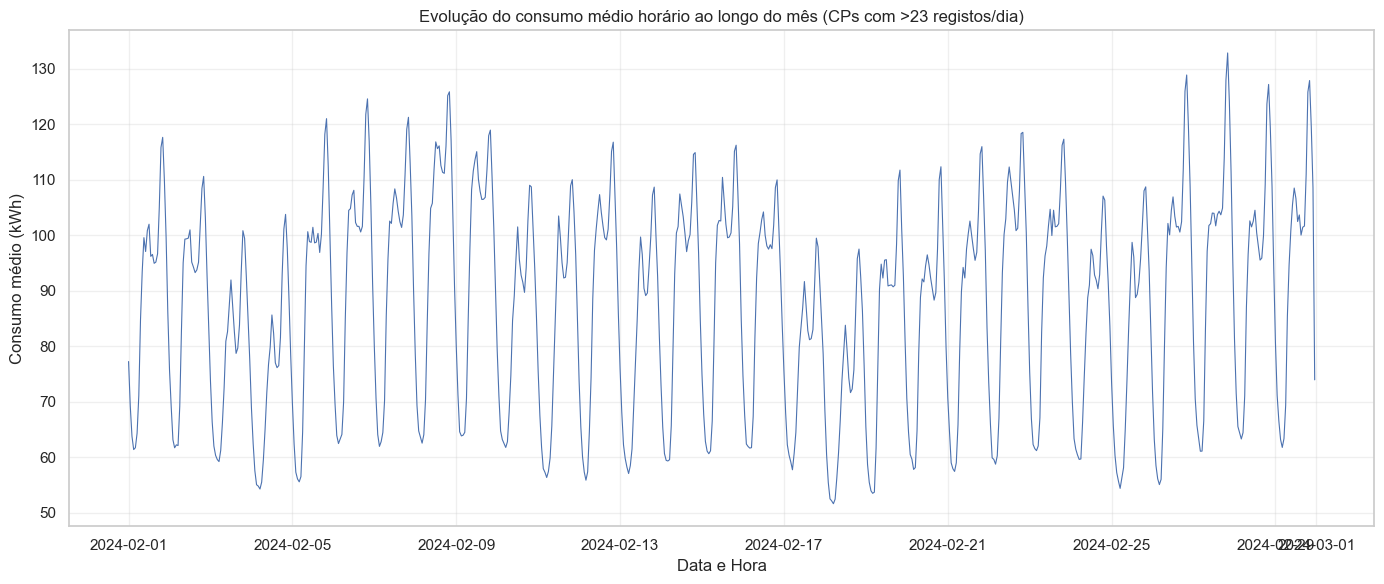

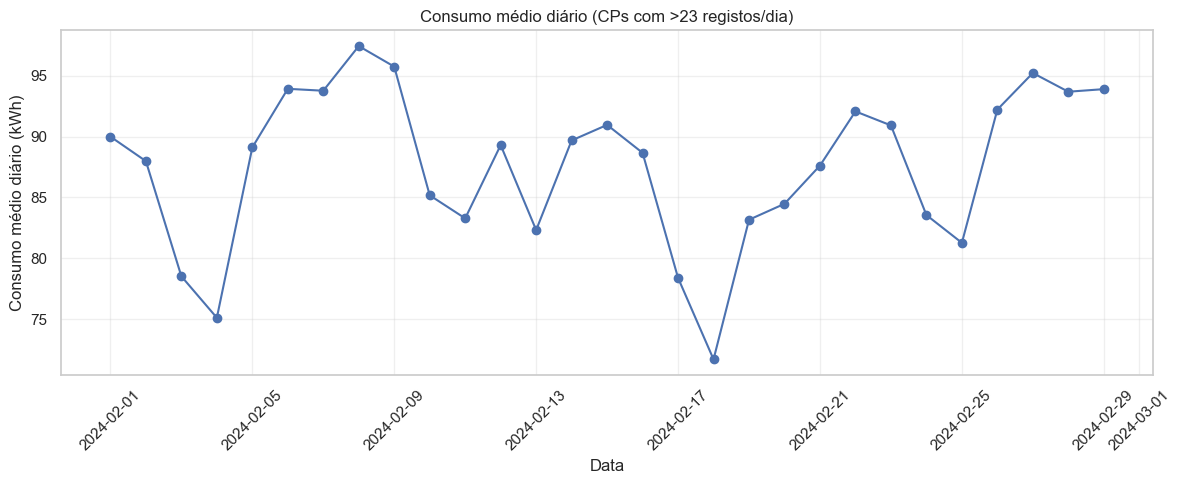

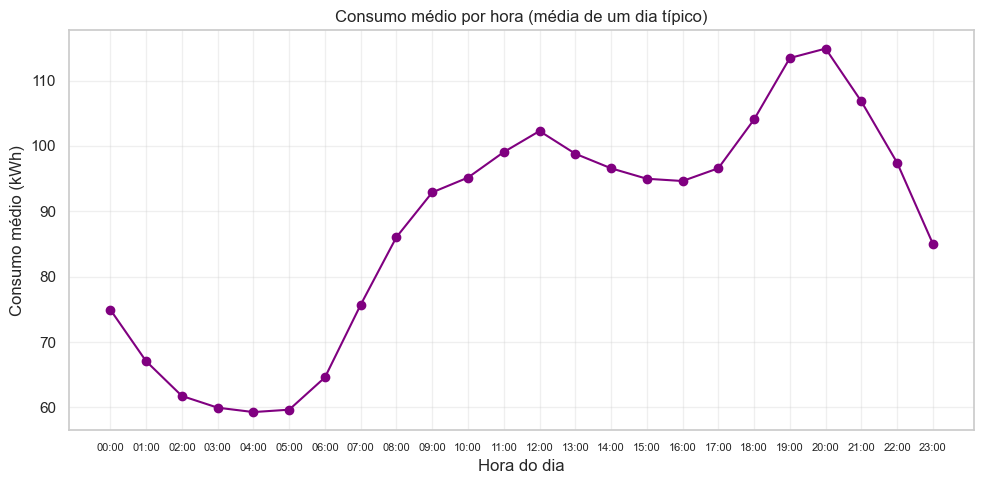

In [118]:
# Garantir que a coluna 'Data' está em formato de data
df_mais_23_registos['Data'] = pd.to_datetime(df_mais_23_registos['Data'])

# Agrupar por data e código postal para calcular o consumo diário
consumo_diario = df_mais_23_registos.groupby(['Data', 'Código Postal'])['Energia ativa (kWh)'].sum().reset_index()

# Usar diretamente a coluna de datetime completa
df_mais_23_registos['Data/Hora'] = pd.to_datetime(df_mais_23_registos['Data/Hora'])

# Agrupar por Data/Hora e calcular média de consumo entre todos os códigos postais
media_horaria_total = df_mais_23_registos.groupby('Data/Hora')['Energia ativa (kWh)'].mean().reset_index()

# Plotar gráfico de linha com a evolução do consumo médio horário
plt.figure(figsize=(14, 6))
plt.plot(media_horaria_total['Data/Hora'], media_horaria_total['Energia ativa (kWh)'], linewidth=0.8)
plt.title('Evolução do consumo médio horário ao longo do mês (CPs com >23 registos/dia)')
plt.xlabel('Data e Hora')
plt.ylabel('Consumo médio (kWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Extrair a data (sem horas) da coluna datetime
media_horaria_total['Data'] = media_horaria_total['Data/Hora'].dt.date

# Agrupar por dia e calcular a média diária dos consumos médios horários
media_diaria = media_horaria_total.groupby('Data')['Energia ativa (kWh)'].mean().reset_index()

# Gráfico de linha com a média diária
plt.figure(figsize=(12, 5))
plt.plot(media_diaria['Data'], media_diaria['Energia ativa (kWh)'], marker='o', linestyle='-')
plt.title('Consumo médio diário (CPs com >23 registos/dia)')
plt.xlabel('Data')
plt.ylabel('Consumo médio diário (kWh)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calcular a média de consumo por hora (média de todas as observações dessa hora ao longo do mês)
media_por_hora = (
    df_mais_23_registos
    .groupby('Hora')['Energia ativa (kWh)']
    .mean()
    .reset_index(name='Consumo médio (kWh)')
)

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(media_por_hora['Hora'], media_por_hora['Consumo médio (kWh)'],
         marker='o', linestyle='-', color='purple')
plt.title('Consumo médio por hora (média de um dia típico)')
plt.xlabel('Hora do dia')
plt.ylabel('Consumo médio (kWh)')
plt.xticks(range(0, 24), fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## nº de cps de 4 digitos distintos dentro do dataset de 7 dig

In [119]:
df_mais_23_registos['CP_4dig'] = df_mais_23_registos['Código Postal'].astype(str).str[:4]
n_cp_4dig_distintos = df_mais_23_registos['CP_4dig'].nunique()

print(n_cp_4dig_distintos)

cp_4dig_lista = sorted(df_mais_23_registos['Código Postal'].astype(str).str[:4].unique().tolist())
print(cp_4dig_lista)

8
['3000', '3020', '3025', '3030', '3040', '3045', '3050', '3060']


# RESUMO DO DATASET DE CP DE 4 DIG (filtrado apenas com os 8 cps da área de estudo) - ANO TODO

In [120]:
consum_3000 = pd.read_csv("consumos_horario_codigo_postal.csv", sep=";")

In [121]:
# Garantir que a coluna está como string
consum_3000['Código Postal'] = consum_3000['Código Postal'].astype(str)

consum_3000 = consum_3000[consum_3000['Código Postal'].astype(str).str[:4].isin(cp_4dig_lista)]
# Filtrar apenas os códigos postais numéricos
consum_3000 = consum_3000[consum_3000['Código Postal'].str.isnumeric()].copy()

# Converter a coluna para inteiro
consum_3000['Código Postal'] = consum_3000['Código Postal'].astype(int)

# Filtrar os códigos postais entre 2900 e 3100
df_filtrado = consum_3000[(consum_3000['Código Postal'] >= 3000) & (consum_3000['Código Postal'] <= 3060)]

# Ordenar por ordem crescente
df_ordenado = df_filtrado.sort_values(by='Código Postal')

# Visualizar
df_ordenado

Data/Hora        Data   Hora  Código Postal  \
3727223  2023-06-03T11:00:00+01:00  2023-06-03  11:00           3000   
3727111  2022-12-26T06:00:00+00:00  2022-12-26  06:00           3000   
3726899  2023-07-09T03:00:00+01:00  2023-07-09  03:00           3000   
3726893  2023-09-10T14:00:00+01:00  2023-09-10  14:00           3000   
3726749  2023-08-19T01:00:00+01:00  2023-08-19  01:00           3000   
...                            ...         ...    ...            ...   
3724188  2023-08-19T20:00:00+01:00  2023-08-19  20:00           3060   
2797371  2023-03-23T20:00:00+00:00  2023-03-23  20:00           3060   
2797071  2023-05-15T20:00:00+01:00  2023-05-15  20:00           3060   
2796914  2022-11-15T17:00:00+00:00  2022-11-15  17:00           3060   
1546712  2023-06-30T04:00:00+01:00  2023-06-30  04:00           3060   

         Energia ativa (kWh) Dia da Semana  
3727223         15753.498911        Sábado  
3727111          9776.402350       Segunda  
3726899          9024.159589       Domingo  
3726893         13305.481289       Domingo  
3726749         10564.738152        Sábado  
...                      ...           ...  
3724188         17605.672618        Sábado  
2797371         30806.731081        Quinta  
2797071         26945.679404       Segunda  
2796914         27988.336221         Terça  
1546712         19877.566285         Sexta  

[64128 rows x 6 columns]

In [122]:
# Assumindo que tens as colunas 'Data' e 'Hora' separadas
# Primeiro, combinar as colunas 'Data' e 'Hora' em uma só coluna 'Data/Hora'

df_ordenado['Data/Hora'] = pd.to_datetime(df_ordenado['Data'].astype(str) + ' ' + df_ordenado['Hora'].astype(str))

# Agora, garantir que a coluna 'Data/Hora' está no formato datetime
df_ordenado['Data/Hora'] = pd.to_datetime(df_ordenado['Data/Hora'])

# Verificar se foi criada corretamente
print(df_ordenado[['Data', 'Hora', 'Data/Hora']].head())

# Extrair data e ordenar
df_ordenado['Dia'] = df_ordenado['Data/Hora'].dt.date
df_ordenado.sort_values(['Código Postal', 'Data/Hora'], inplace=True)

# Calcular os intervalos entre registos (por código postal e dia)
df_ordenado['delta_min'] = df_ordenado.groupby(['Código Postal', 'Dia'])['Data/Hora'].diff().dt.total_seconds() / 60

# Resumo estatístico por código postal e dia
resumo4dig = df_ordenado.groupby(['Código Postal', 'Dia']).agg(
    n_registos4dig=('Data/Hora', 'count'),
    consumo_total4dig=('Energia ativa (kWh)', 'sum'),
    intervalo_médio_min4dig=('delta_min', 'mean'),
    intervalo_mínimo_min4dig=('delta_min', 'min'),
    intervalo_máximo_min4dig=('delta_min', 'max'),
    tempo_coberto_horas4dig=('Data/Hora', lambda x: (x.max() - x.min()).total_seconds() / 3600)
).reset_index()

print(resumo4dig.head())

               Data   Hora           Data/Hora
3727223  2023-06-03  11:00 2023-06-03 11:00:00
3727111  2022-12-26  06:00 2022-12-26 06:00:00
3726899  2023-07-09  03:00 2023-07-09 03:00:00
3726893  2023-09-10  14:00 2023-09-10 14:00:00
3726749  2023-08-19  01:00 2023-08-19 01:00:00
   Código Postal         Dia  n_registos4dig  consumo_total4dig  \
0           3000  2022-11-01              24      258559.110334   
1           3000  2022-11-02              24      343013.853757   
2           3000  2022-11-03              24      334729.629834   
3           3000  2022-11-04              24      352545.654059   
4           3000  2022-11-05              24      316697.142397   

   intervalo_médio_min4dig  intervalo_mínimo_min4dig  \
0                     60.0                      60.0   
1                     60.0                      60.0   
2                     60.0                      60.0   
3                     60.0                      60.0   
4                     60.0         

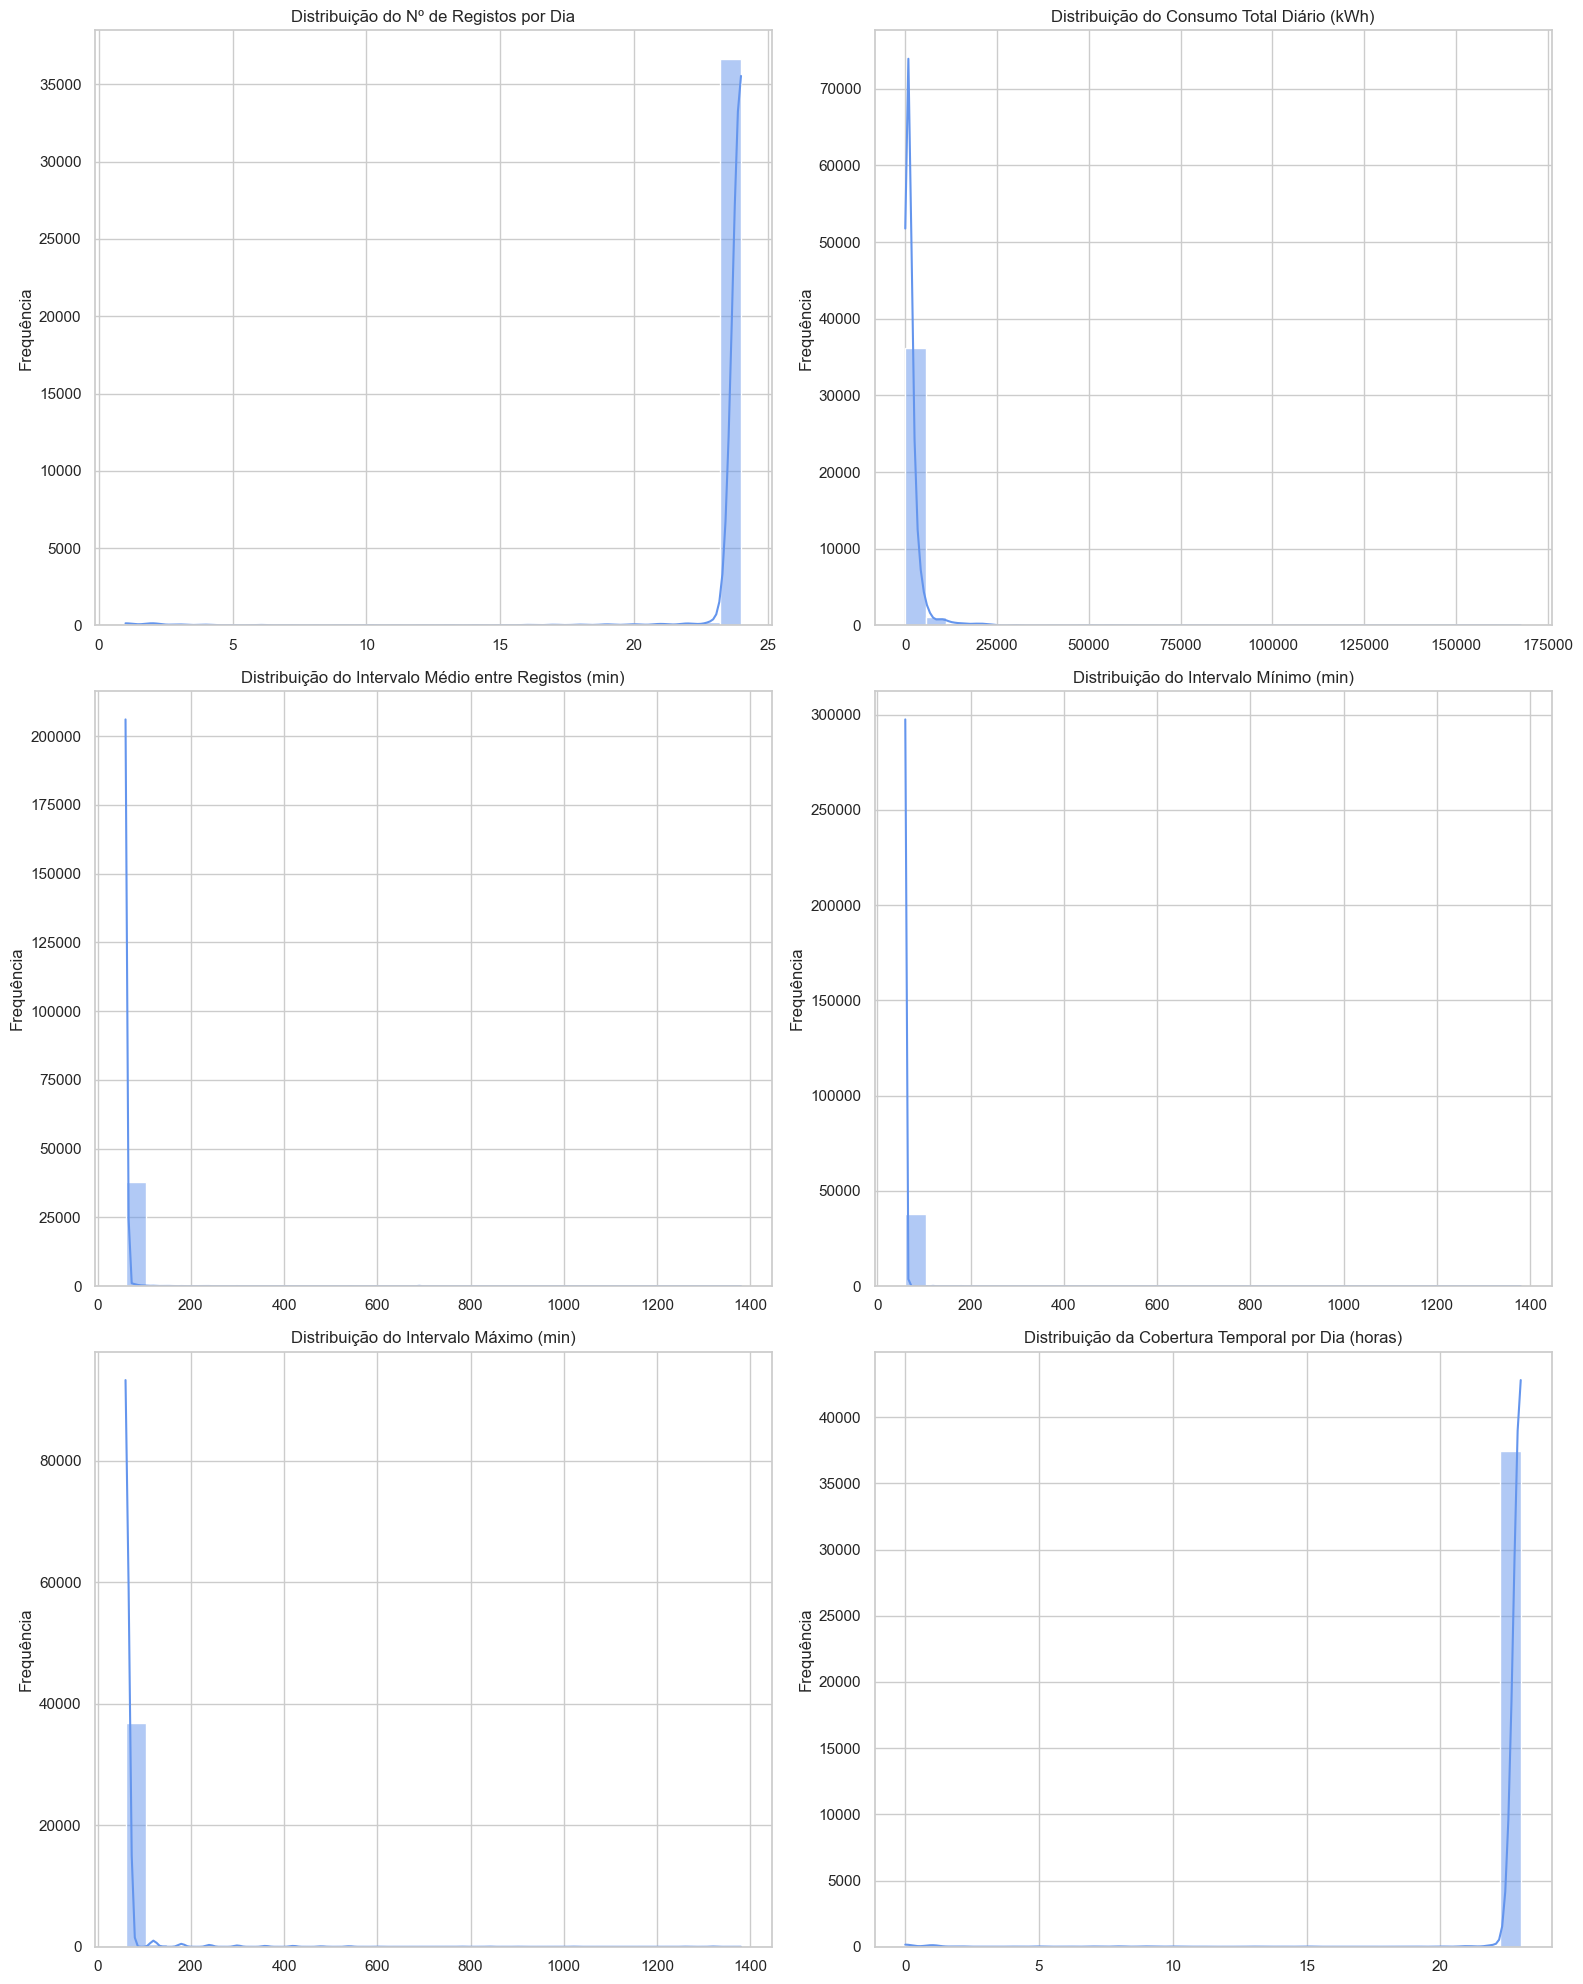

In [123]:
sns.set(style="whitegrid")

# Lista de métricas a visualizar
metricas4dig = [
    'n_registos',
    'consumo_total',
    'intervalo_médio_min',
    'intervalo_mínimo_min',
    'intervalo_máximo_min',
    'tempo_coberto_horas'
]

# Títulos para os gráficos
titulos = {
    'n_registos': 'Distribuição do Nº de Registos por Dia',
    'consumo_total': 'Distribuição do Consumo Total Diário (kWh)',
    'intervalo_médio_min': 'Distribuição do Intervalo Médio entre Registos (min)',
    'intervalo_mínimo_min': 'Distribuição do Intervalo Mínimo (min)',
    'intervalo_máximo_min': 'Distribuição do Intervalo Máximo (min)',
    'tempo_coberto_horas': 'Distribuição da Cobertura Temporal por Dia (horas)'
}

# Tamanho da figura
plt.figure(figsize=(16, 20))

# Criar subplots para cada métrica
for i, metrica in enumerate(metricas4dig, 1):
    plt.subplot(3, 2, i)
    sns.histplot(resumo[metrica], bins=30, kde=True, color='cornflowerblue')
    plt.title(titulos[metrica])
    plt.xlabel('')
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

### NORMALIZADO

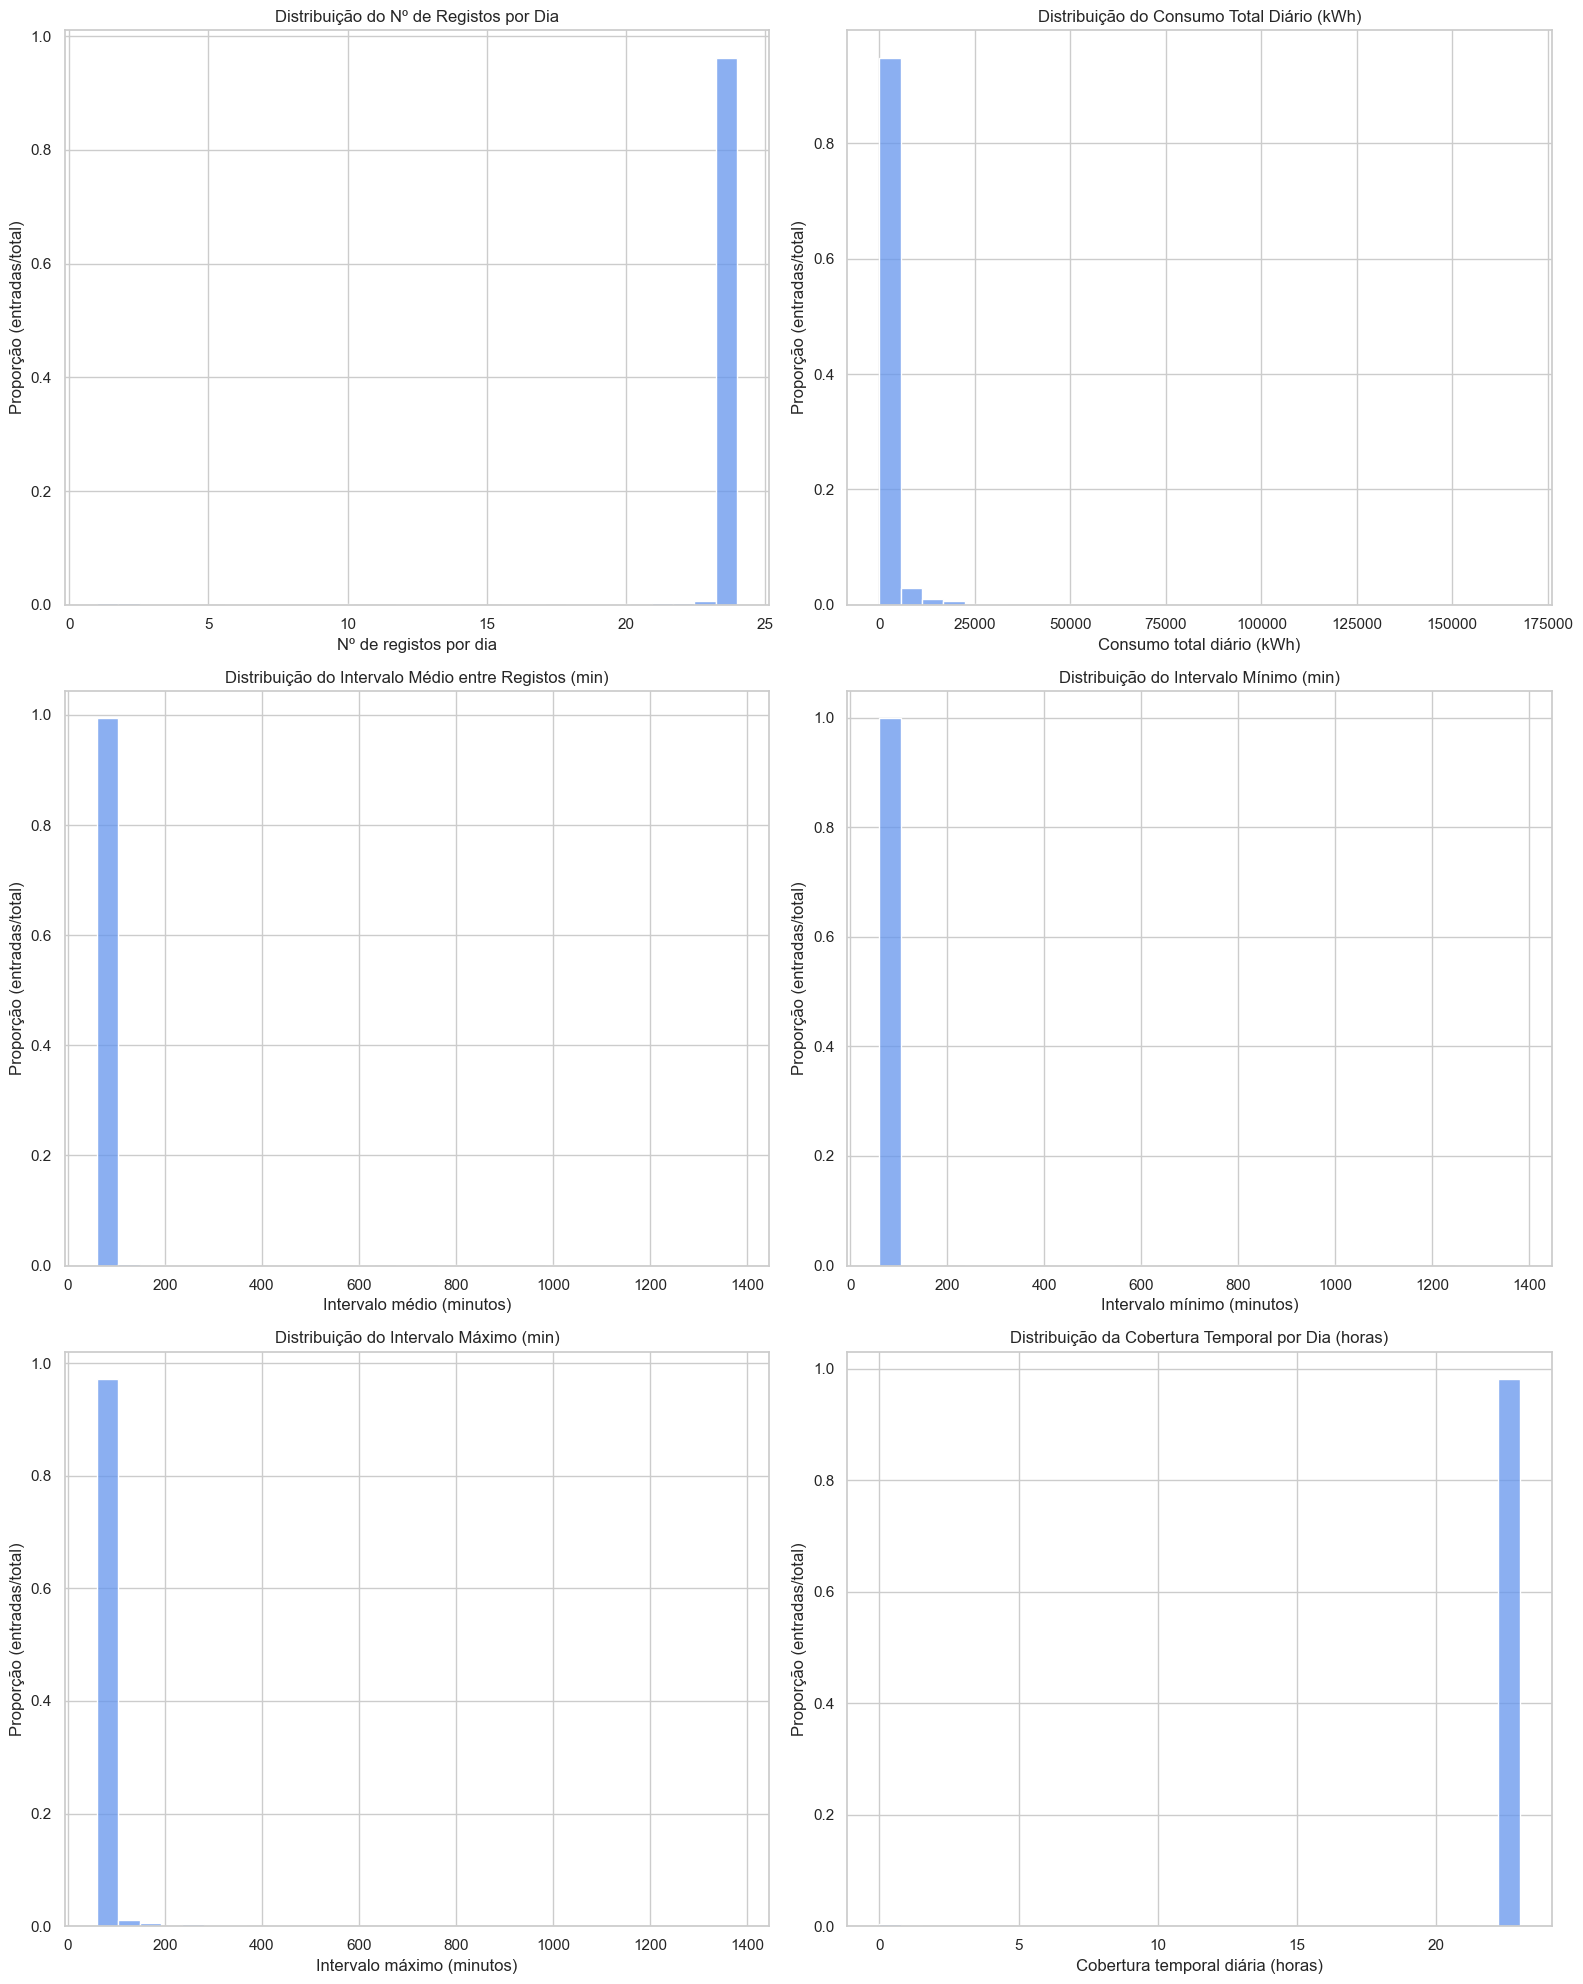

In [124]:

sns.set(style="whitegrid")

metricas4dig = [
    'n_registos',
    'consumo_total',
    'intervalo_médio_min',
    'intervalo_mínimo_min',
    'intervalo_máximo_min',
    'tempo_coberto_horas'
]

titulos = {
    'n_registos': 'Distribuição do Nº de Registos por Dia',
    'consumo_total': 'Distribuição do Consumo Total Diário (kWh)',
    'intervalo_médio_min': 'Distribuição do Intervalo Médio entre Registos (min)',
    'intervalo_mínimo_min': 'Distribuição do Intervalo Mínimo (min)',
    'intervalo_máximo_min': 'Distribuição do Intervalo Máximo (min)',
    'tempo_coberto_horas': 'Distribuição da Cobertura Temporal por Dia (horas)'
}

labels_x = {
    'n_registos': 'Nº de registos por dia',
    'consumo_total': 'Consumo total diário (kWh)',
    'intervalo_médio_min': 'Intervalo médio (minutos)',
    'intervalo_mínimo_min': 'Intervalo mínimo (minutos)',
    'intervalo_máximo_min': 'Intervalo máximo (minutos)',
    'tempo_coberto_horas': 'Cobertura temporal diária (horas)'
}

plt.figure(figsize=(16, 20))

for i, metrica in enumerate(metricas4dig, 1):
    plt.subplot(3, 2, i)
    
    # Obtem valores e normaliza para proporções
    dados = resumo[metrica].dropna()
    total = len(dados)
    sns.histplot(dados, bins=30, stat="probability", kde=False, color='cornflowerblue')
    
    plt.title(titulos[metrica])
    plt.xlabel(labels_x[metrica])
    plt.ylabel('Proporção (entradas/total)')

plt.tight_layout()
plt.show()


## RESUMO EM TABELA, COM MEDIDAS DE TENDÊNCIA CENTRAL, QUARTIS, ETC.

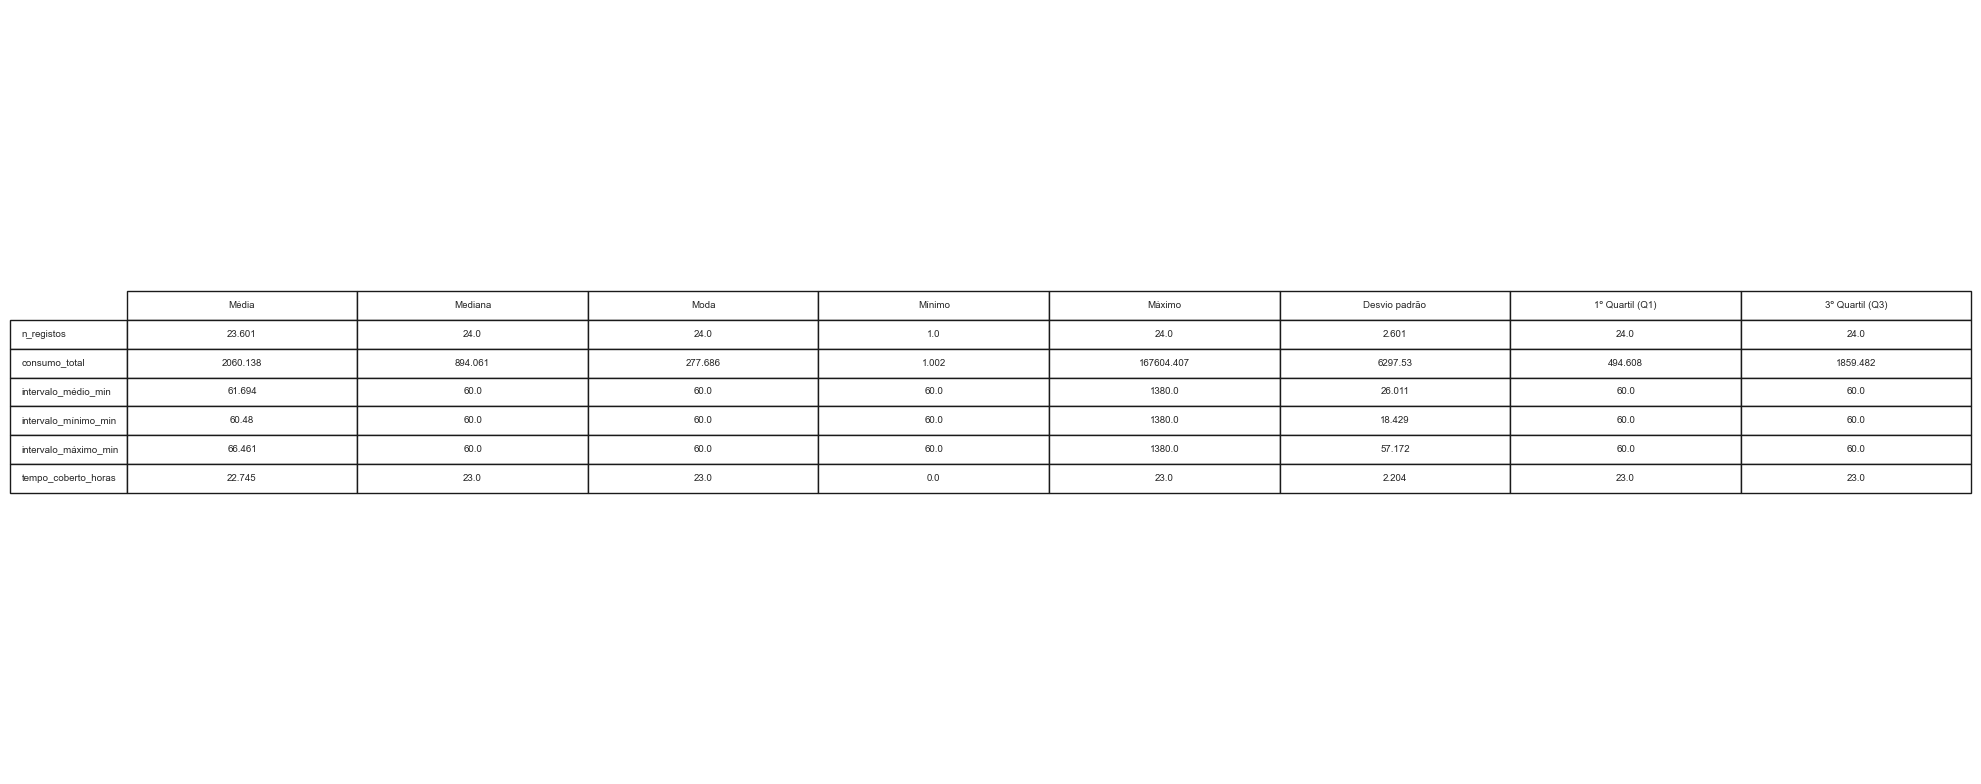

In [125]:
from scipy.stats import mode

# Métricas a analisar
metricas4dig = [
    'n_registos',
    'consumo_total',
    'intervalo_médio_min',
    'intervalo_mínimo_min',
    'intervalo_máximo_min',
    'tempo_coberto_horas'
]

# Tabela descritiva
estatisticas = {}

for metrica in metricas4dig:
    serie = resumo[metrica].dropna()

    moda_val, moda_count = mode(serie, keepdims=True)

    estatisticas[metrica] = {
        'Média': serie.mean(),
        'Mediana': serie.median(),
        'Moda': moda_val[0] if len(moda_val) > 0 else np.nan,
        'Mínimo': serie.min(),
        'Máximo': serie.max(),
        'Desvio padrão': serie.std(),
        '1º Quartil (Q1)': serie.quantile(0.25),
        '3º Quartil (Q3)': serie.quantile(0.75),
    }

# Criar DataFrame final
df_estatisticas4dig = pd.DataFrame(estatisticas).T.round(3)

# Criar imagem da tabela
fig, ax = plt.subplots(figsize=(20, 8))
ax.axis('off')
tbl = ax.table(
    cellText=df_estatisticas.values,
    colLabels=df_estatisticas.columns,
    rowLabels=df_estatisticas.index,
    cellLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(7)
tbl.scale(1.2, 1.4)

plt.tight_layout()
plt.show()

In [126]:
# Garantir que a coluna 'Data' está em formato datetime
df_ordenado['Data'] = pd.to_datetime(df_ordenado['Data'])

# Agrupar por código postal e data, contando o número de registos por dia
registos_por_dia = df_ordenado.groupby(['Código Postal', df_ordenado['Data'].dt.date]).size()

# Verificar quantos códigos postais têm menos de 23 registos por dia
cp_com_menos_23_registos = registos_por_dia.groupby('Código Postal').apply(lambda x: (x < 23).sum())

# Contar o número de códigos postais que têm pelo menos um dia com menos de 23 registos
num_cp_com_menos_23 = (cp_com_menos_23_registos > 0).sum()

proporcao_menos_23 = (cp_com_menos_23_registos > 0).sum() / len(cp_com_menos_23_registos)

print(f"Proporção de códigos postais que não têm 23 ou mais registos por dia: {proporcao_menos_23:.2f}")

print(f"Número de códigos postais que não têm 23 ou mais registos por dia: {num_cp_com_menos_23}")


Proporção de códigos postais que não têm 23 ou mais registos por dia: 0.00
Número de códigos postais que não têm 23 ou mais registos por dia: 0


In [127]:
# Criar pasta de saída, se necessário
os.makedirs("resultados_consumo4dig", exist_ok=True)

for cp4 in cp_4dig_lista:
    # Filtrar para este CP
    df_cp = df_ordenado[df_ordenado['Código Postal'].astype(str).str.startswith(cp4)].copy()
    
    if df_cp.empty:
        continue  # ignora CPs sem dados

    # Garantir datetime e criar campos temporais
    df_cp['Data/Hora'] = pd.to_datetime(df_cp['Data/Hora'])
    df_cp['Data'] = df_cp['Data/Hora'].dt.date
    df_cp['Hora'] = df_cp['Data/Hora'].dt.hour
    df_cp['Mês'] = df_cp['Data/Hora'].dt.to_period('M').astype(str)

    # Calcular consumo diário
    consumo_diario = df_cp.groupby('Data')['Energia ativa (kWh)'].sum().reset_index()

    # Obter dia de maior e menor consumo
    dia_min = consumo_diario.loc[consumo_diario['Energia ativa (kWh)'].idxmin(), 'Data']
    dia_max = consumo_diario.loc[consumo_diario['Energia ativa (kWh)'].idxmax(), 'Data']

    # Gravar o DataFrame filtrado
    nome_csv = f"resultados_consumo4dig/cons_anual{cp4}.csv"
    df_cp.to_csv(nome_csv, index=False)

## estatisticas para todo o conjunto

In [128]:
df_ordenado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64128 entries, 2381651 to 2400732
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Data/Hora            64128 non-null  datetime64[ns]
 1   Data                 64128 non-null  datetime64[ns]
 2   Hora                 64128 non-null  object        
 3   Código Postal        64128 non-null  int64         
 4   Energia ativa (kWh)  64128 non-null  float64       
 5   Dia da Semana        64128 non-null  object        
 6   Dia                  64128 non-null  object        
 7   delta_min            61456 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 4.4+ MB


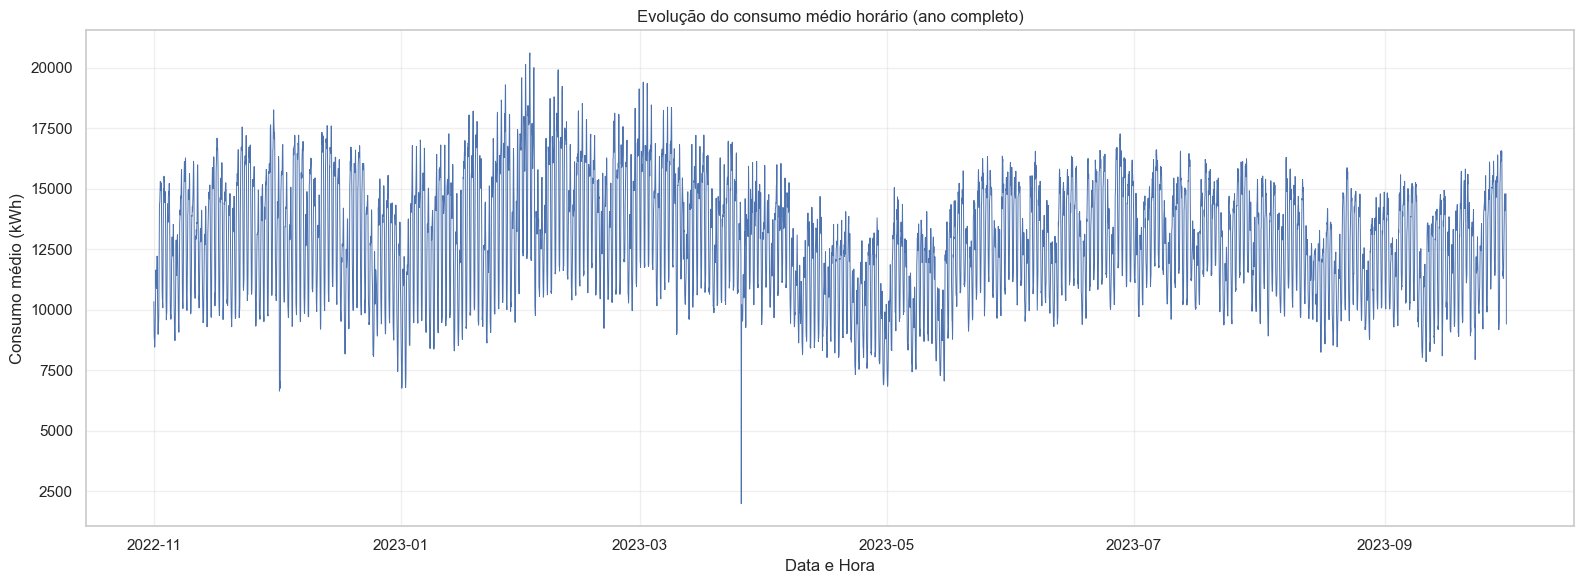

Primeiro dia do dataset: 2022-11-01
Último dia do dataset: 2023-09-30
10


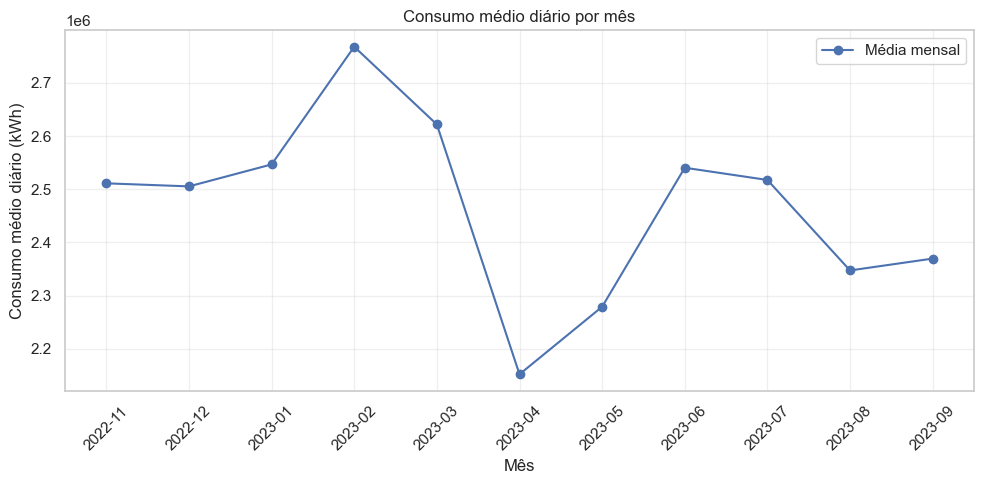

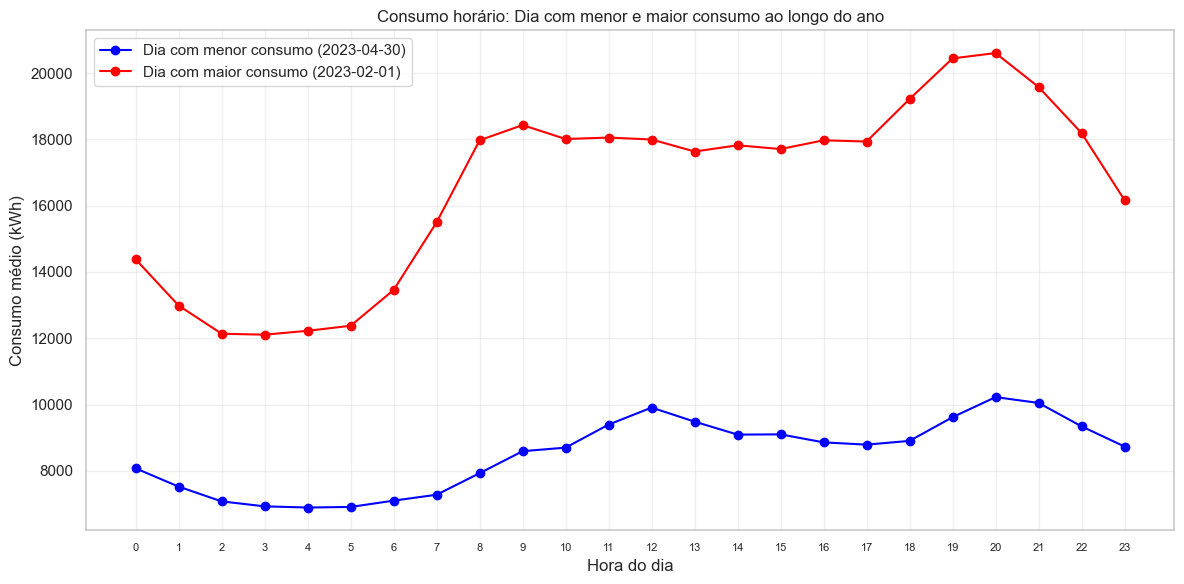

In [129]:

# Garantir datetime
df_ordenado['Data/Hora'] = pd.to_datetime(df_ordenado['Data/Hora'])

# Extrair campos temporais
df_ordenado['Data'] = df_ordenado['Data/Hora'].dt.date
df_ordenado['Hora'] = df_ordenado['Data/Hora'].dt.hour
df_ordenado['Mês'] = df_ordenado['Data/Hora'].dt.to_period('M').astype(str)

# 1. EVOLUÇÃO DO CONSUMO MÉDIO HORÁRIO (ao longo do ano todo)
media_horaria_total = df_ordenado.groupby('Data/Hora')['Energia ativa (kWh)'].mean().reset_index()

plt.figure(figsize=(16, 6))
plt.plot(media_horaria_total['Data/Hora'], media_horaria_total['Energia ativa (kWh)'], linewidth=0.7)
plt.title('Evolução do consumo médio horário (ano completo)')
plt.xlabel('Data e Hora')
plt.ylabel('Consumo médio (kWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Obter o primeiro e o último dia do dataset
primeiro_dia = df_ordenado['Data/Hora'].min().date()
ultimo_dia = df_ordenado['Data/Hora'].max().date()

print(f"Primeiro dia do dataset: {primeiro_dia}")
print(f"Último dia do dataset: {ultimo_dia}")

# Calcular a diferença entre o primeiro e o último dia em meses
amplitude_meses = (ultimo_dia.year - primeiro_dia.year) * 12 + ultimo_dia.month - primeiro_dia.month

print(amplitude_meses)

# 2. CONSUMO MÉDIO DIÁRIO POR MÊS (1 linha por mês)
consumo_diario = df_ordenado.groupby('Data')['Energia ativa (kWh)'].sum().reset_index()
consumo_diario['Mês'] = pd.to_datetime(consumo_diario['Data']).dt.to_period('M').astype(str)
media_mensal = consumo_diario.groupby('Mês')['Energia ativa (kWh)'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(media_mensal['Mês'], media_mensal['Energia ativa (kWh)'],
         marker='o', linestyle='-', label='Média mensal')
plt.title('Consumo médio diário por mês')
plt.xlabel('Mês')
plt.ylabel('Consumo médio diário (kWh)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Garantir datetime
df_ordenado['Data/Hora'] = pd.to_datetime(df_ordenado['Data/Hora'])

# Extrair campos temporais
df_ordenado['Data'] = df_ordenado['Data/Hora'].dt.date
df_ordenado['Hora'] = df_ordenado['Data/Hora'].dt.hour

# Calcular o consumo diário
consumo_diario = df_ordenado.groupby('Data')['Energia ativa (kWh)'].sum().reset_index()

# Encontrar os dias com menor e maior consumo ao longo do ano
dia_min = consumo_diario.loc[consumo_diario['Energia ativa (kWh)'].idxmin(), 'Data']
dia_max = consumo_diario.loc[consumo_diario['Energia ativa (kWh)'].idxmax(), 'Data']

# Filtrar os dados para o dia com menor consumo
df_dia_min = df_ordenado[df_ordenado['Data'] == dia_min]
media_dia_min = df_dia_min.groupby('Hora')['Energia ativa (kWh)'].mean().reset_index()

# Filtrar os dados para o dia com maior consumo
df_dia_max = df_ordenado[df_ordenado['Data'] == dia_max]
media_dia_max = df_dia_max.groupby('Hora')['Energia ativa (kWh)'].mean().reset_index()

# Criar gráfico com duas linhas: menor e maior consumo ao longo do ano
plt.figure(figsize=(12, 6))

plt.plot(media_dia_min['Hora'], media_dia_min['Energia ativa (kWh)'],
         marker='o', linestyle='-', label=f'Dia com menor consumo ({dia_min})', color='blue')
plt.plot(media_dia_max['Hora'], media_dia_max['Energia ativa (kWh)'],
         marker='o', linestyle='-', label=f'Dia com maior consumo ({dia_max})', color='red')

plt.title('Consumo horário: Dia com menor e maior consumo ao longo do ano')
plt.xlabel('Hora do dia')
plt.ylabel('Consumo médio (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24), fontsize=8)
plt.tight_layout()
plt.show()

## estatisticas para cada cp individual

In [130]:
print(set(cp_4dig_lista) - set(df_ordenado['Código Postal'].unique()))

{'3030', '3045', '3025', '3050', '3060', '3020', '3000', '3040'}


In [131]:
cp_4dig_lista

['3000', '3020', '3025', '3030', '3040', '3045', '3050', '3060']

In [132]:
df_ordenado['Código Postal'].unique()

array([3000, 3020, 3025, 3030, 3040, 3045, 3050, 3060])

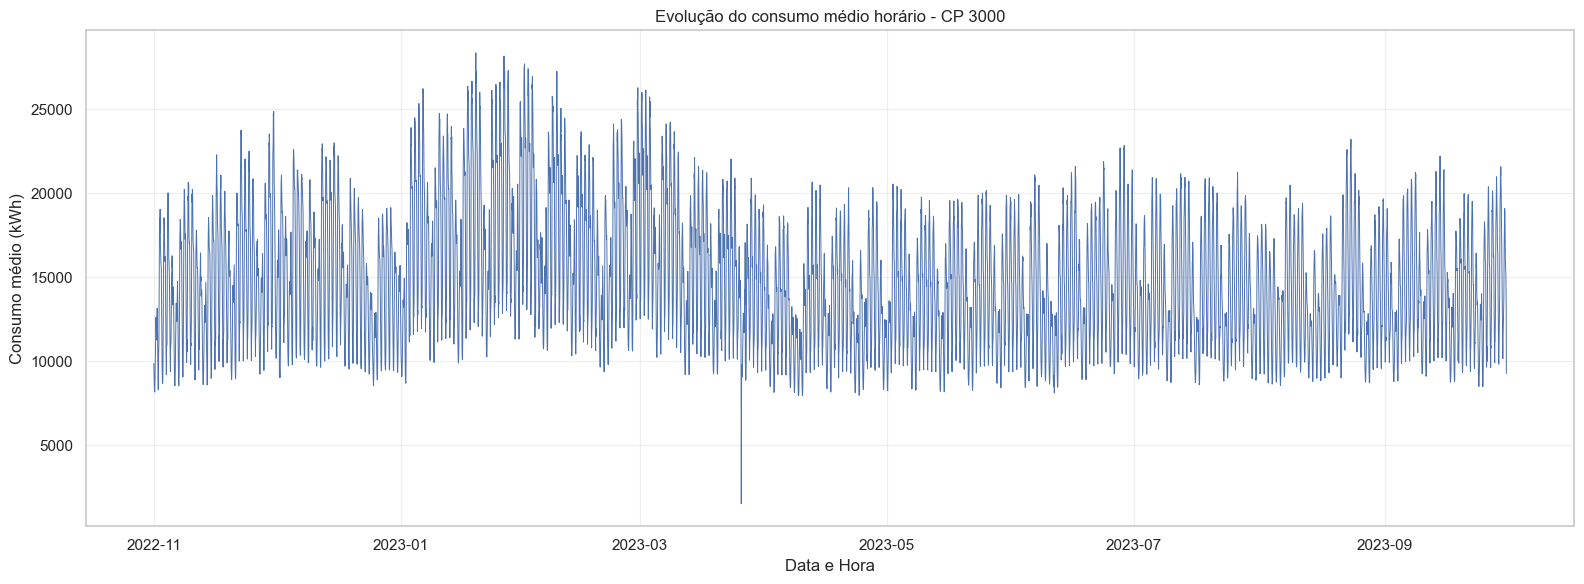

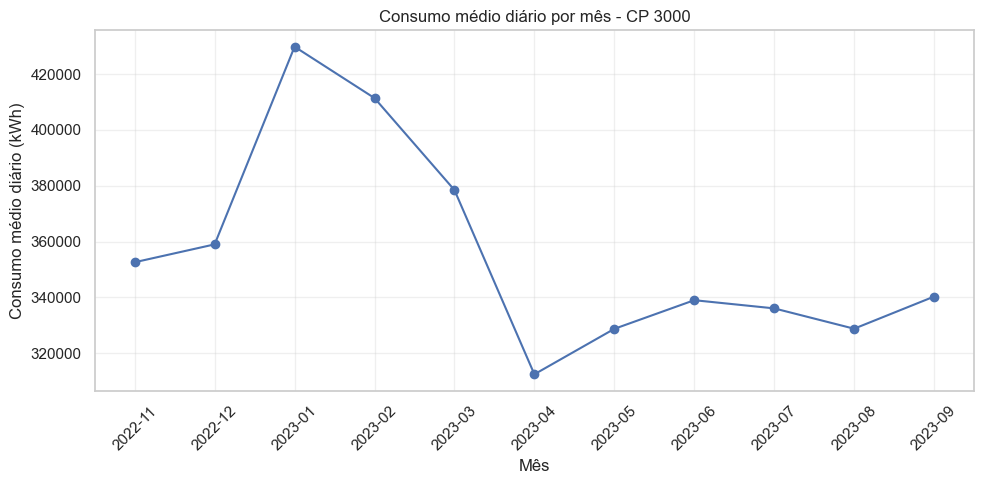

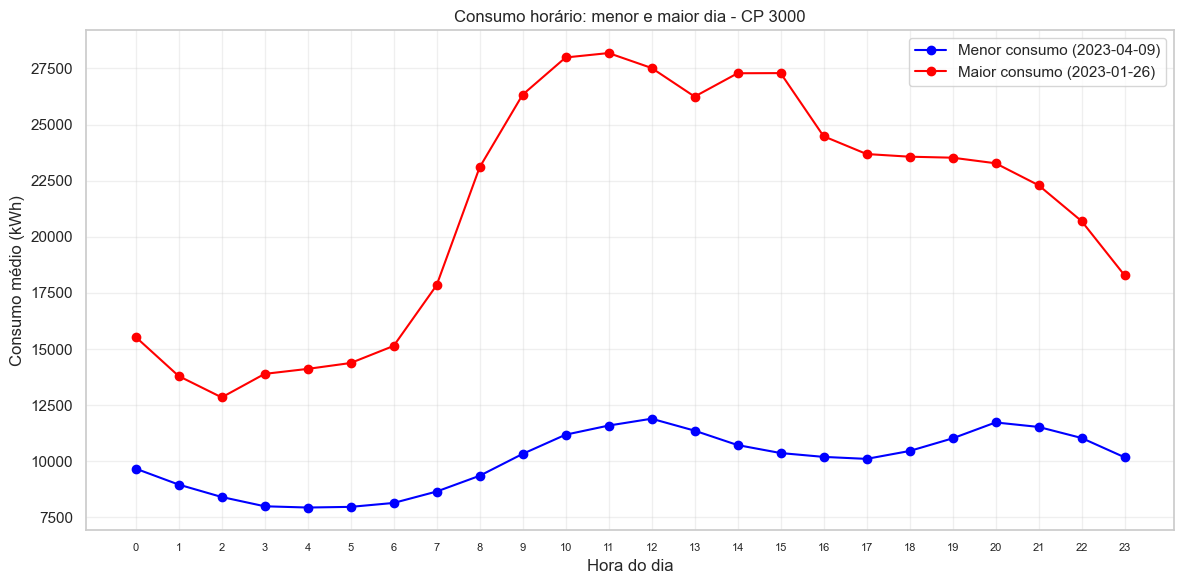

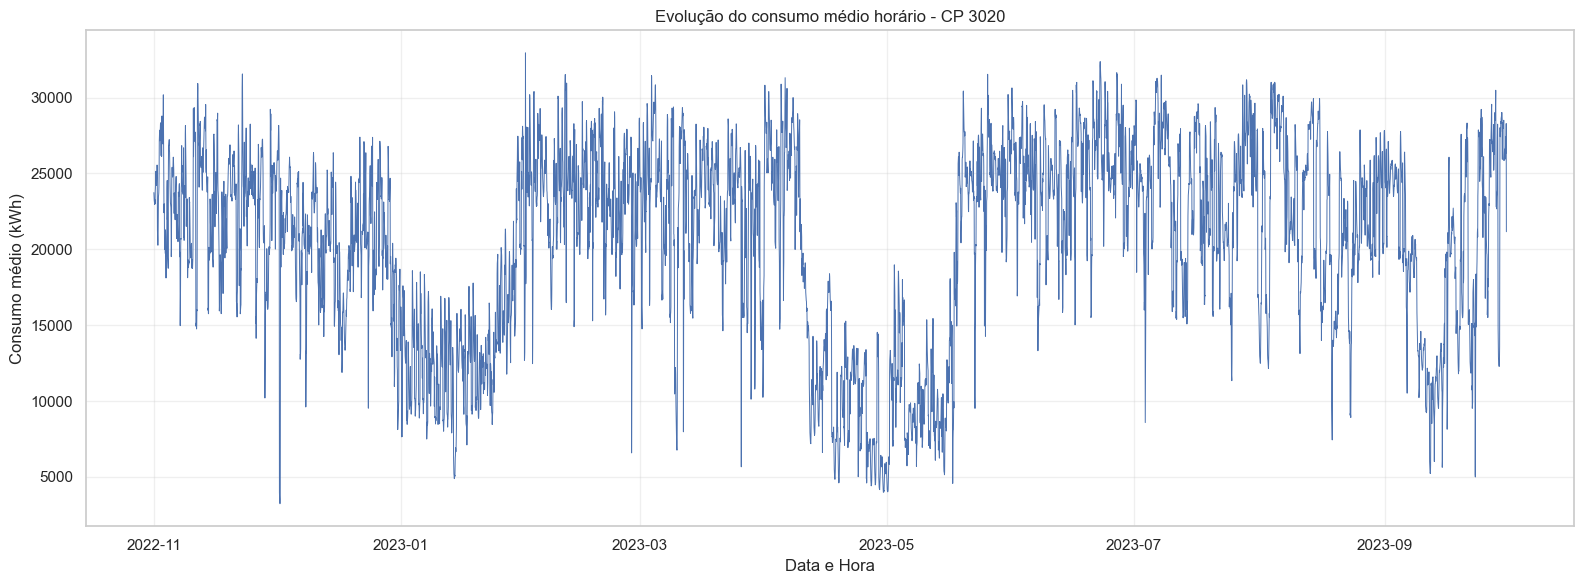

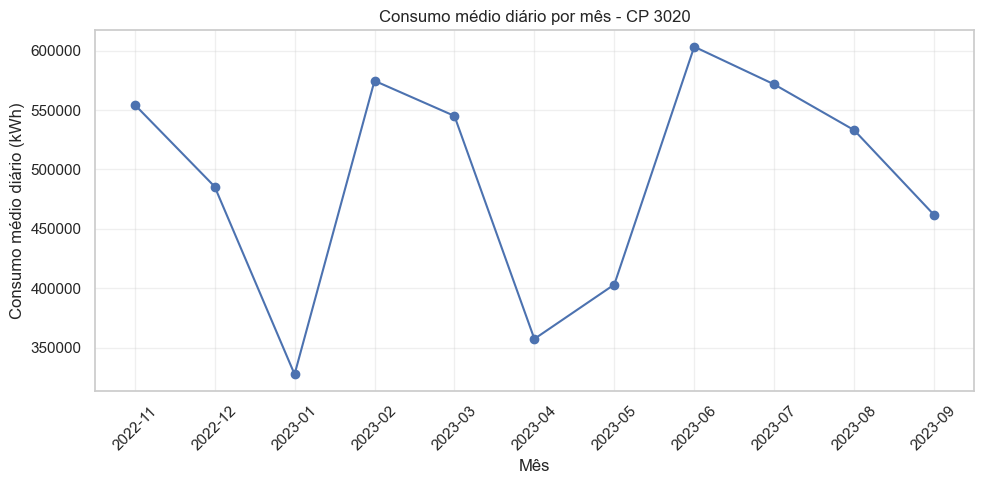

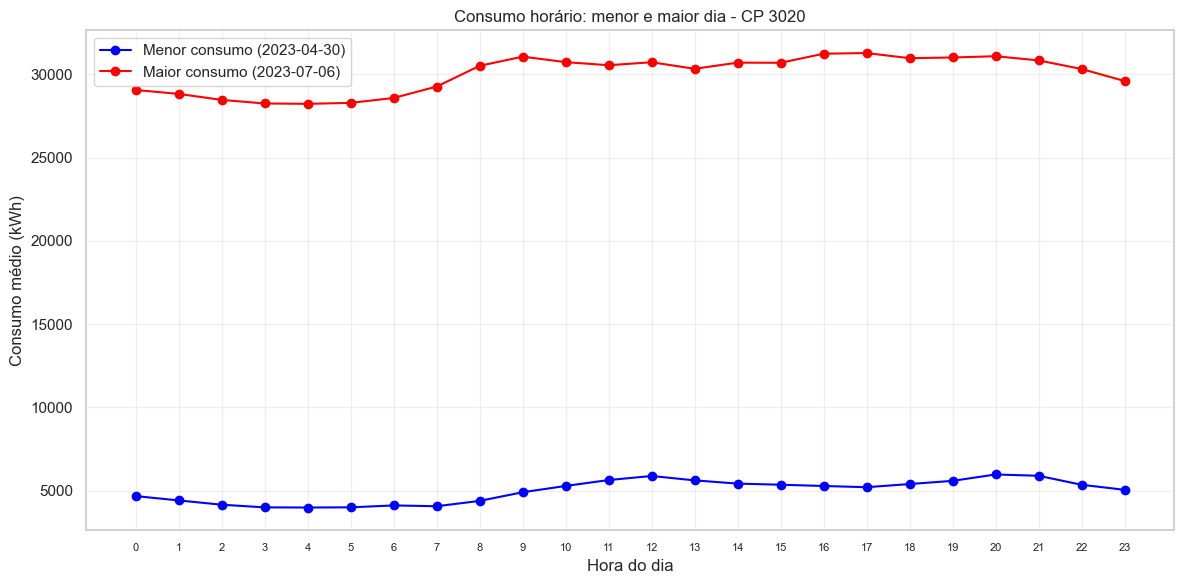

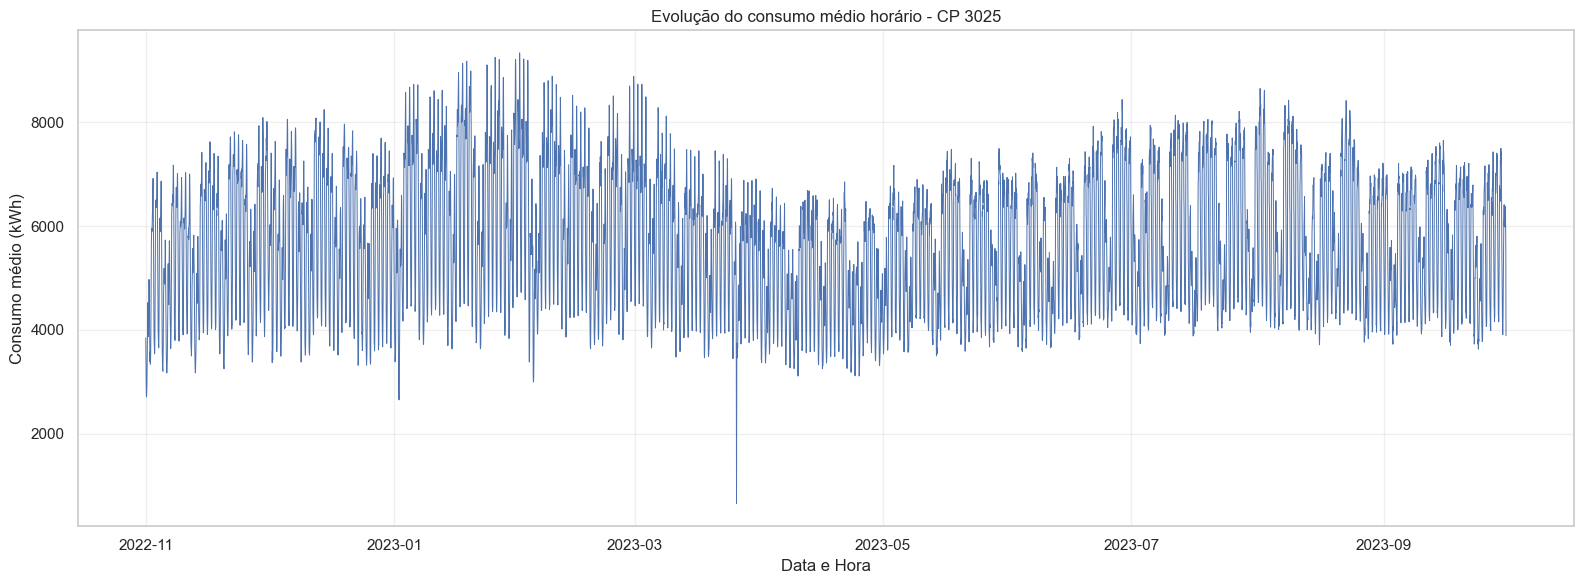

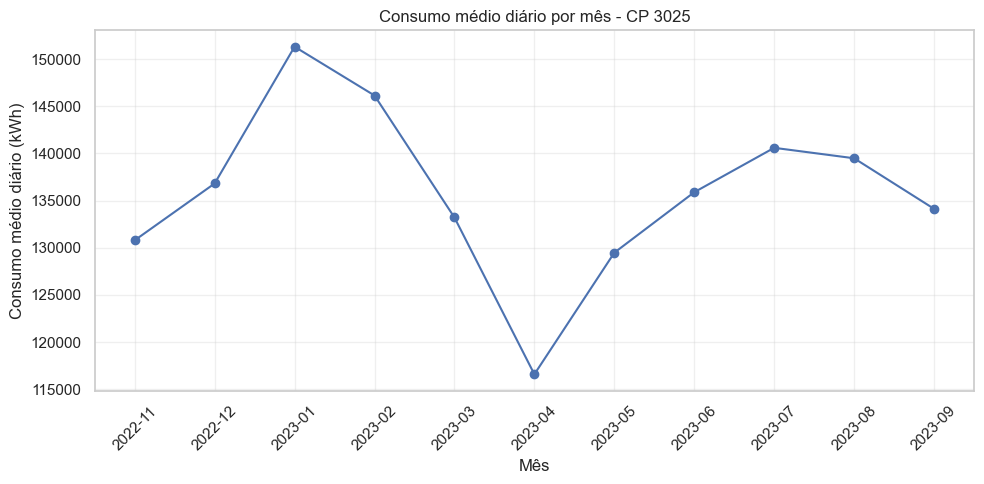

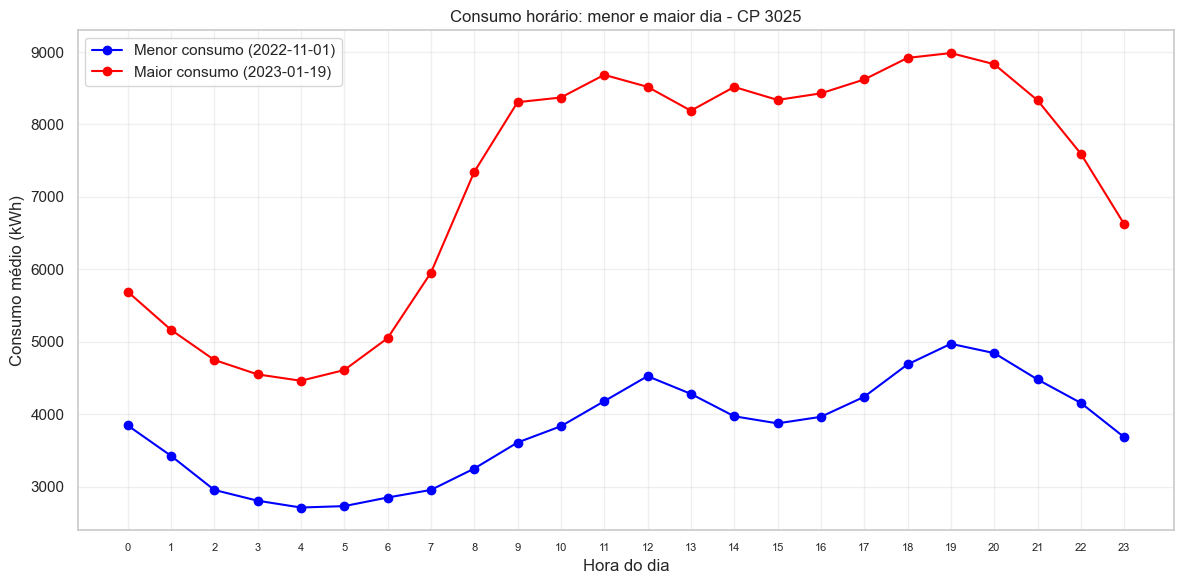

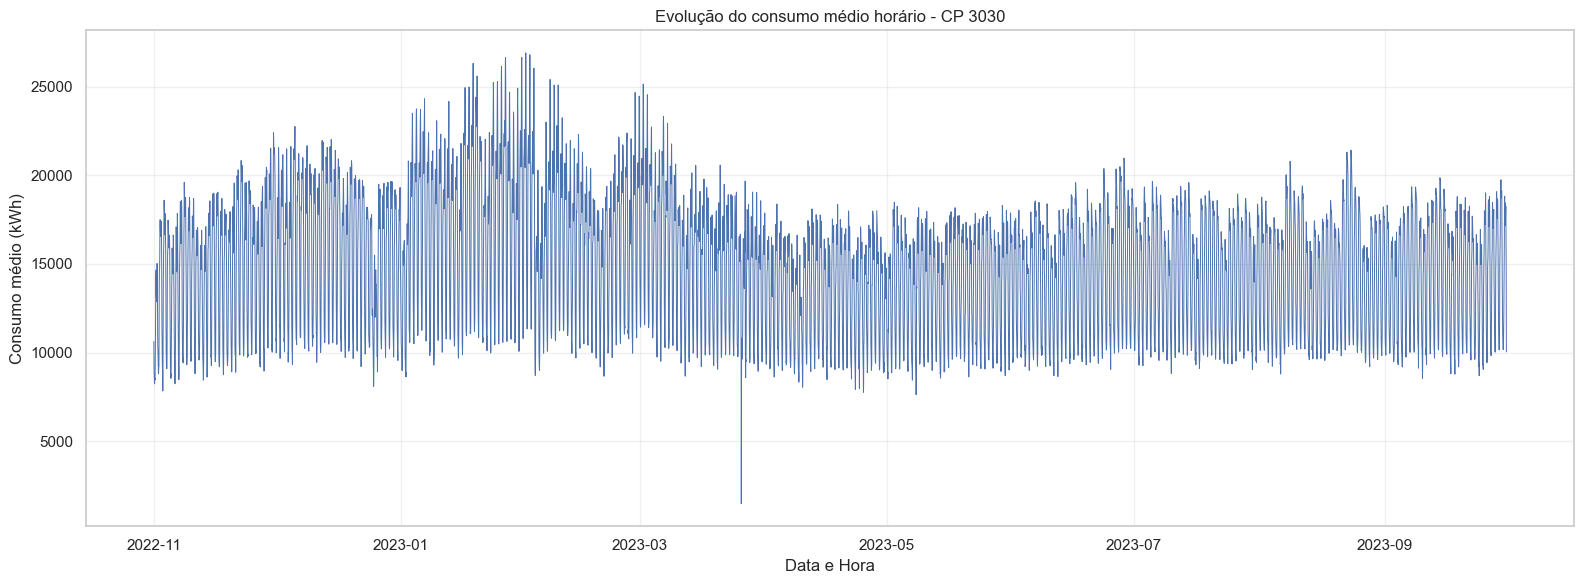

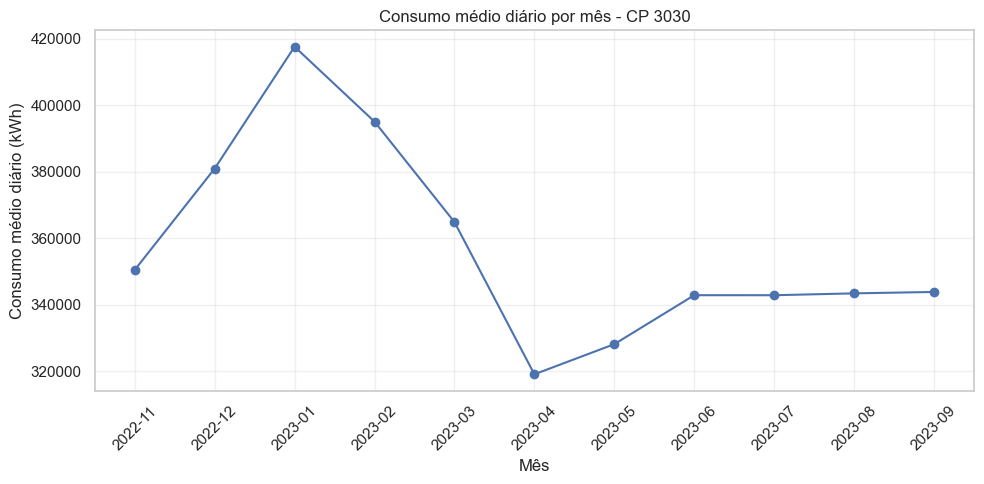

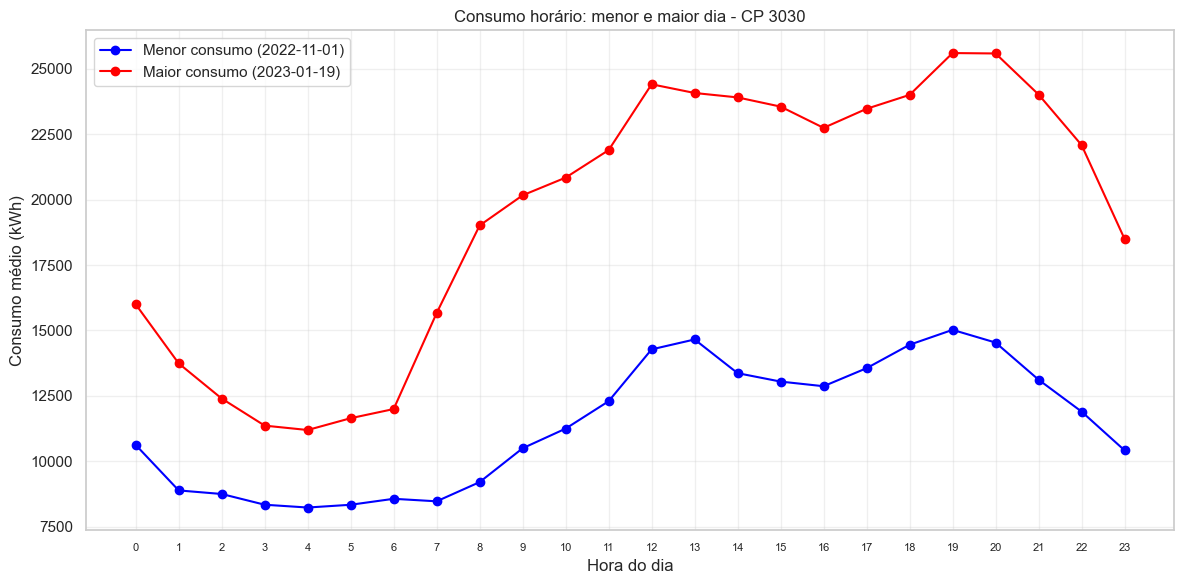

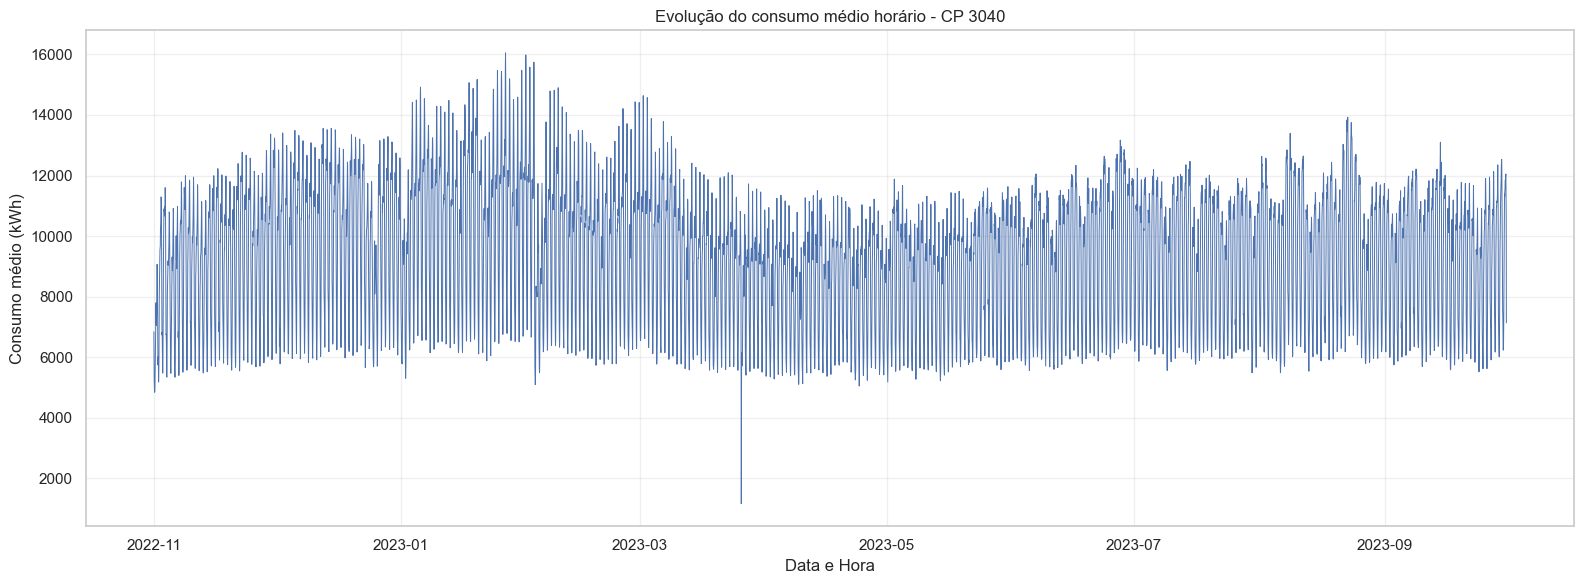

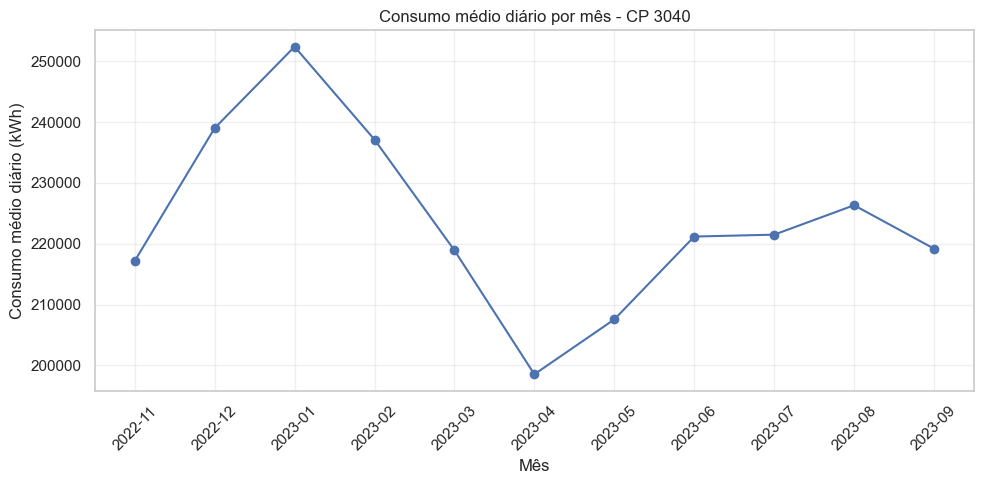

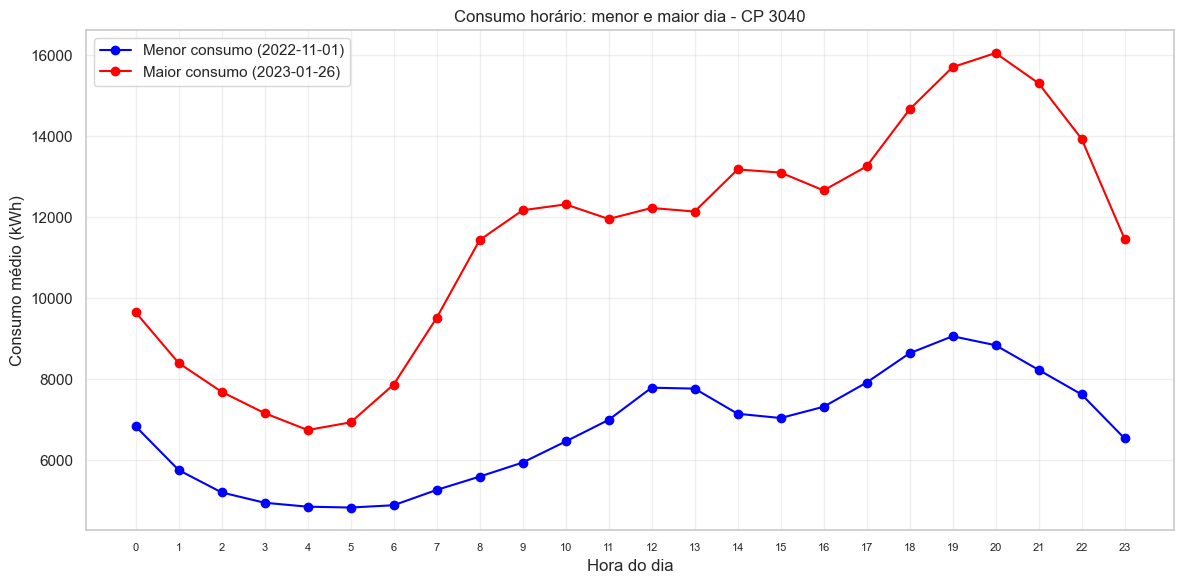

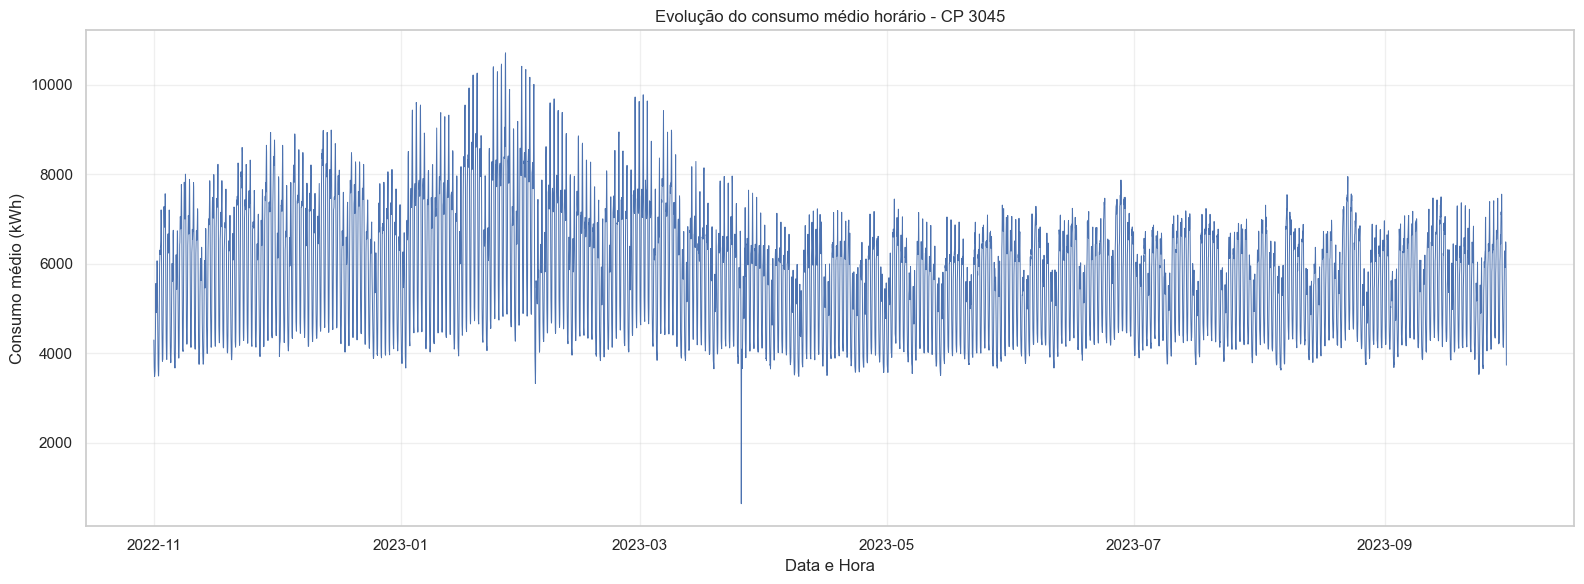

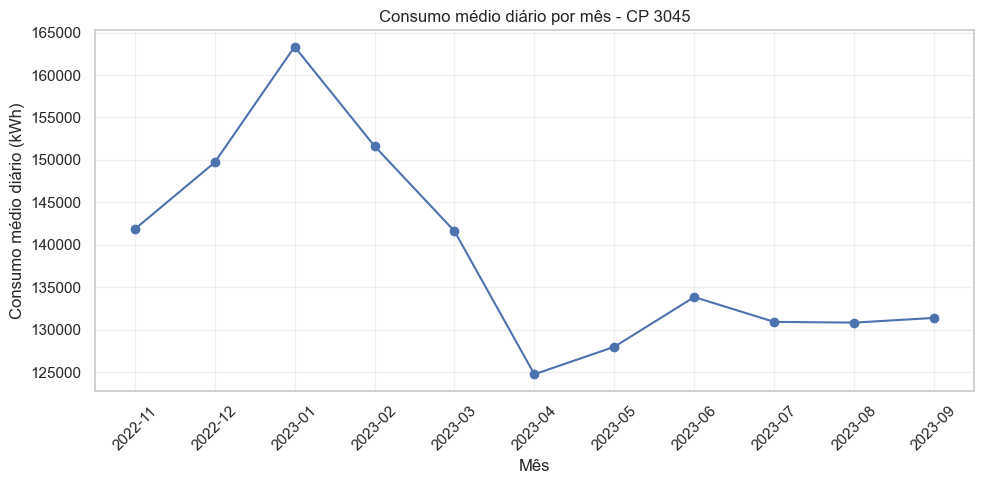

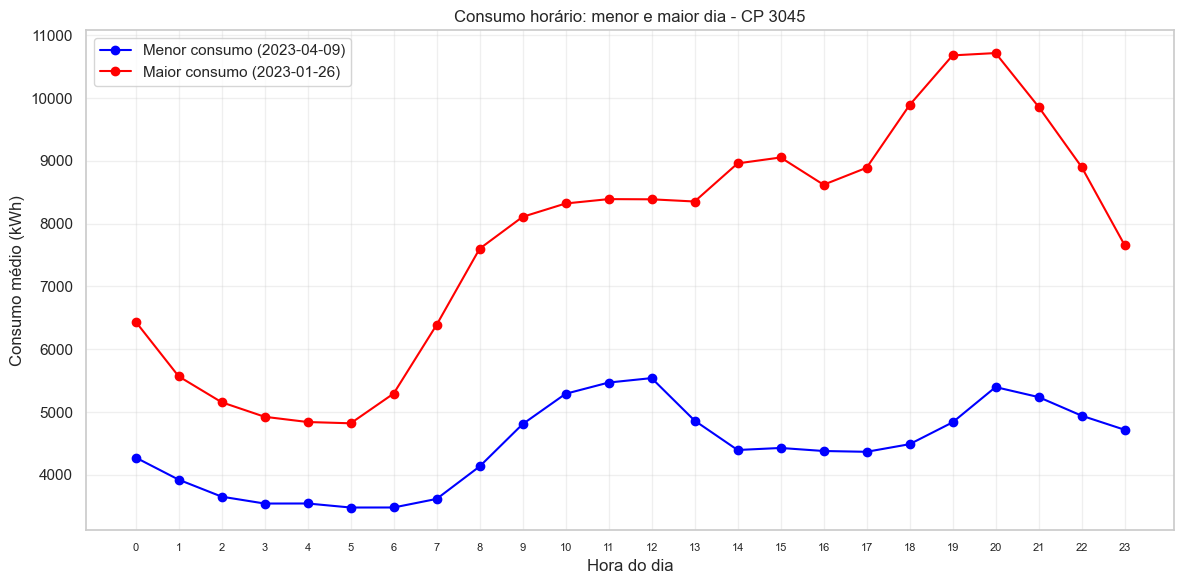

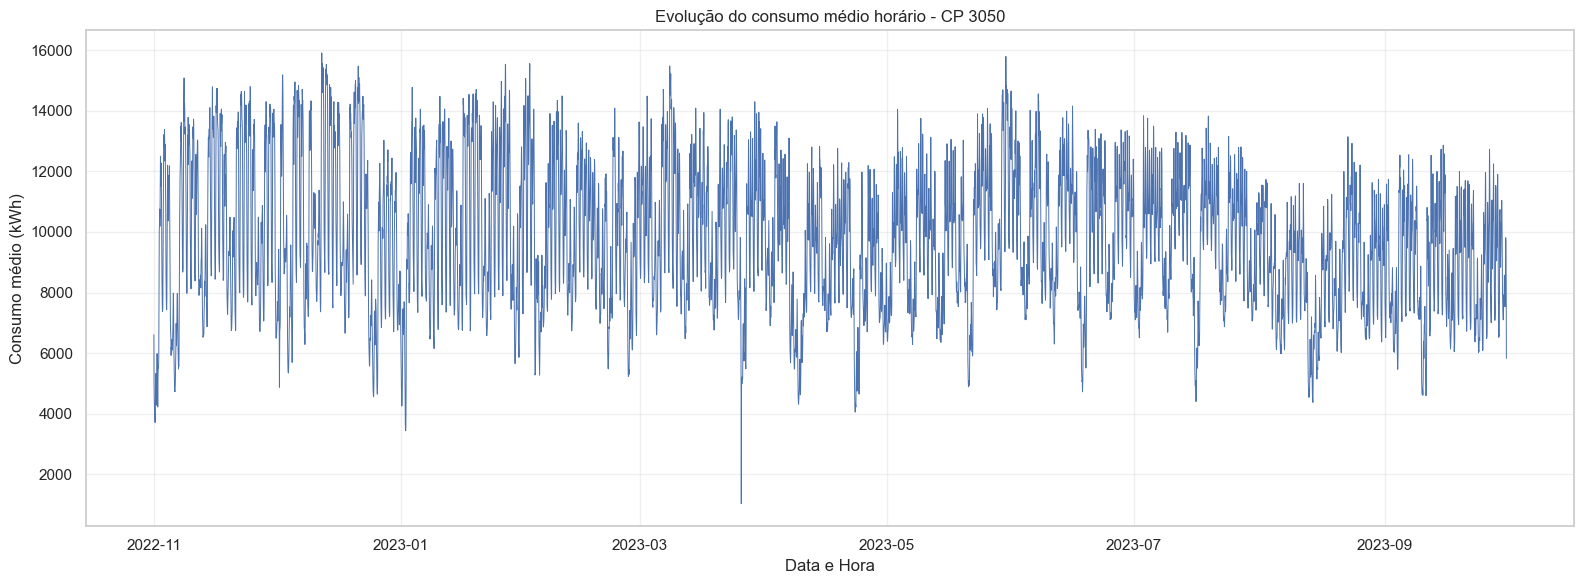

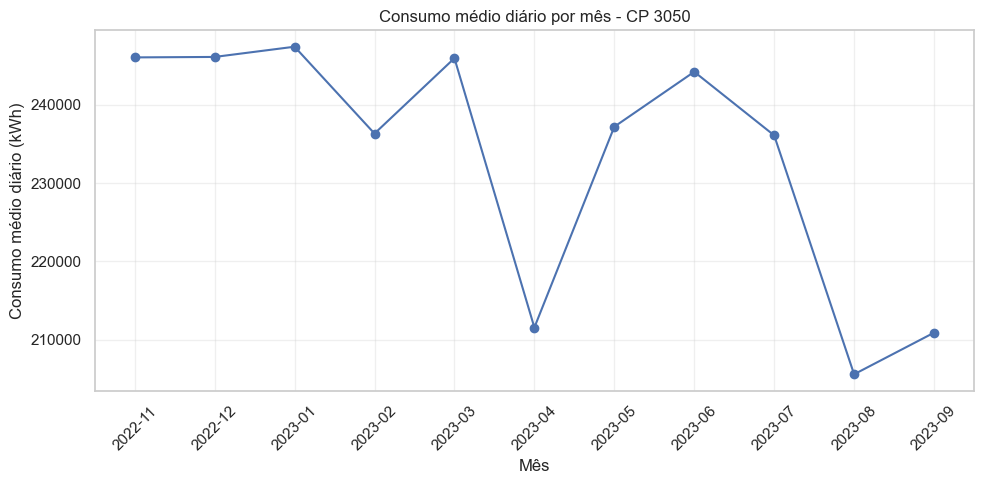

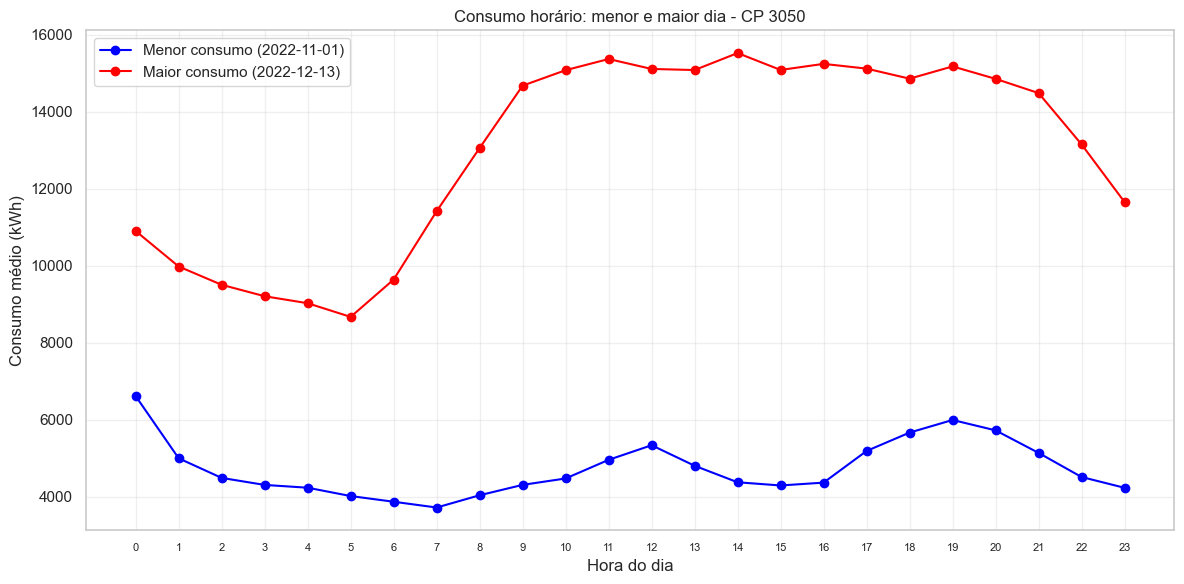

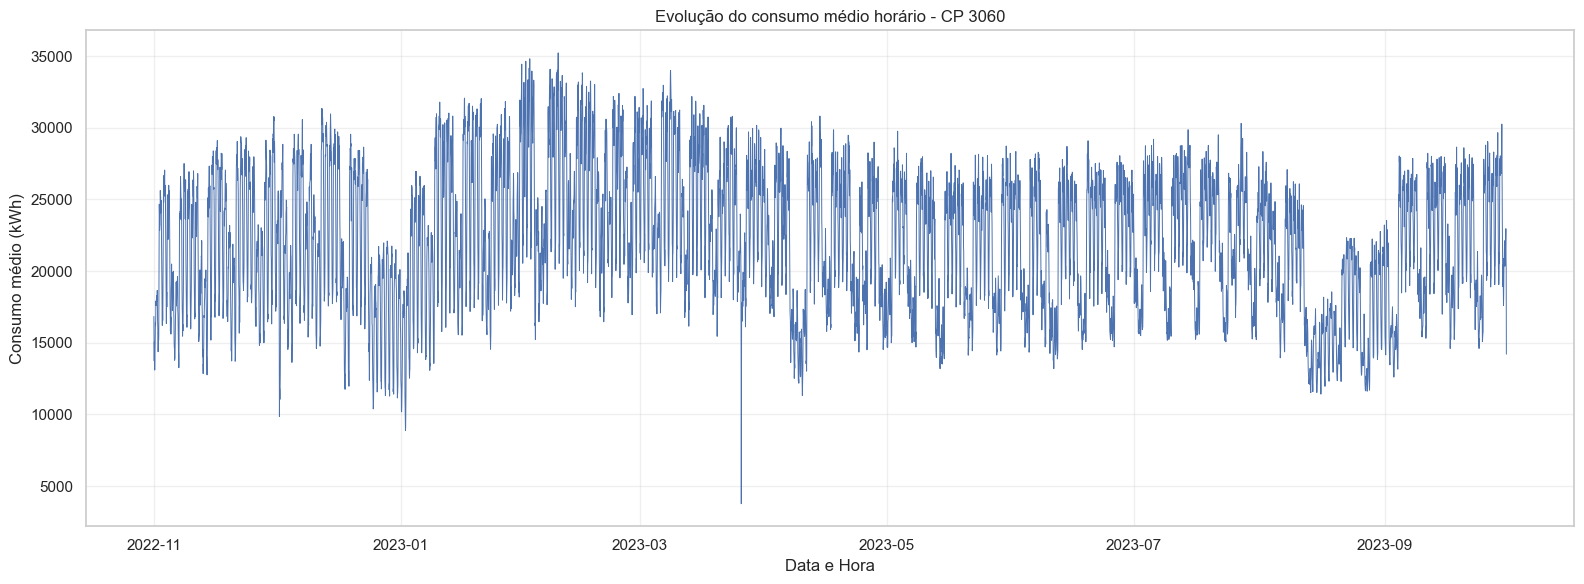

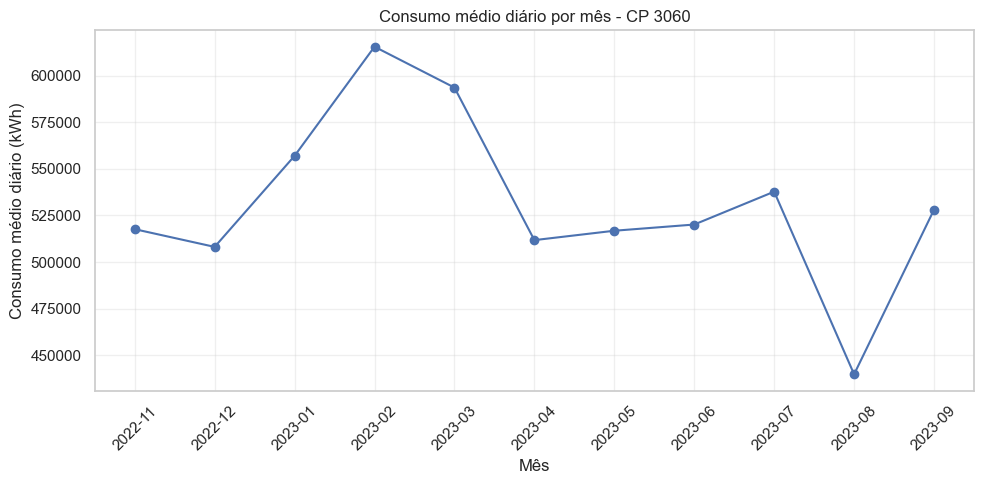

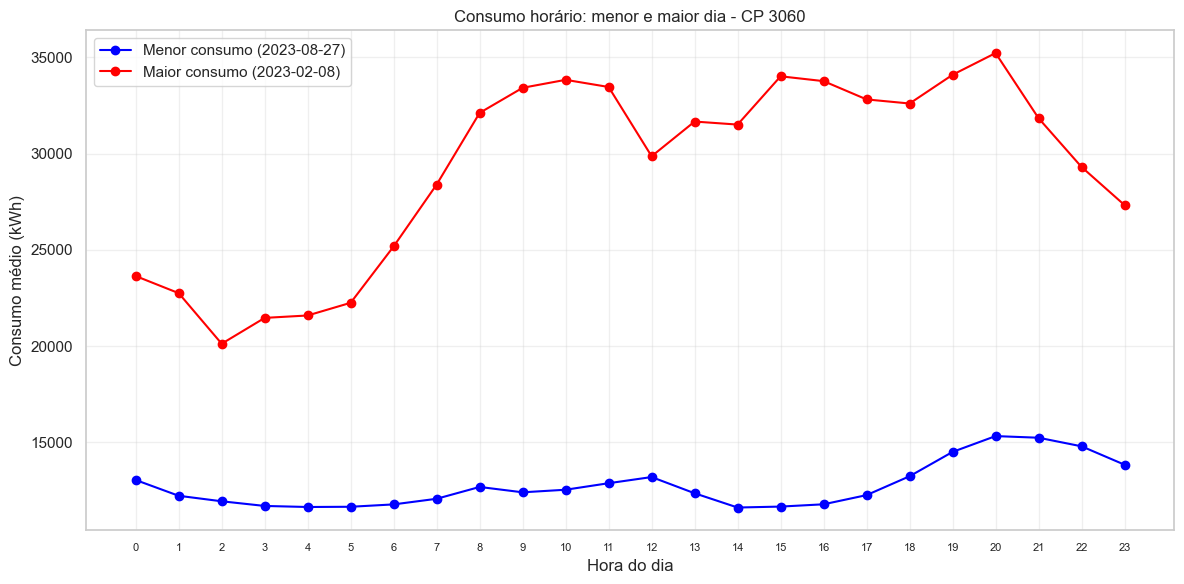

In [133]:
cp_4dig_lista = [int(cp) for cp in cp_4dig_lista]
df_ordenado = df_ordenado.sort_values(by='Data/Hora')
for cp4 in cp_4dig_lista:
    df_cp = df_ordenado[df_ordenado['Código Postal'] == cp4].copy()
    df_cp = df_ordenado[df_ordenado['Código Postal'] == cp4].copy()
    if df_cp.empty:
        print(f"Sem dados para o CP {cp4}, a saltar...")
        continue
    # 1. Evolução do consumo médio horário
    media_horaria_total = df_cp.groupby('Data/Hora')['Energia ativa (kWh)'].mean().reset_index()
    plt.figure(figsize=(16, 6))
    plt.plot(media_horaria_total['Data/Hora'], media_horaria_total['Energia ativa (kWh)'], linewidth=0.7)
    plt.title(f'Evolução do consumo médio horário - CP {cp4}')
    plt.xlabel('Data e Hora')
    plt.ylabel('Consumo médio (kWh)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Consumo médio diário por mês
    consumo_diario = df_cp.groupby('Data')['Energia ativa (kWh)'].sum().reset_index()
    consumo_diario['Mês'] = pd.to_datetime(consumo_diario['Data']).astype(str).str[:7]
    media_mensal = consumo_diario.groupby('Mês')['Energia ativa (kWh)'].mean().reset_index()
    plt.figure(figsize=(10, 5))
    plt.plot(media_mensal['Mês'], media_mensal['Energia ativa (kWh)'], marker='o', linestyle='-')
    plt.title(f'Consumo médio diário por mês - CP {cp4}')
    plt.xlabel('Mês')
    plt.ylabel('Consumo médio diário (kWh)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3. Consumo horário: dia com menor e maior consumo
    consumo_por_dia = df_cp.groupby('Data')['Energia ativa (kWh)'].sum()
    dia_min = consumo_por_dia.idxmin()
    dia_max = consumo_por_dia.idxmax()

    df_dia_min = df_cp[df_cp['Data'] == dia_min]
    media_dia_min = df_dia_min.groupby('Hora')['Energia ativa (kWh)'].mean().reset_index()
    df_dia_max = df_cp[df_cp['Data'] == dia_max]
    media_dia_max = df_dia_max.groupby('Hora')['Energia ativa (kWh)'].mean().reset_index()

    plt.figure(figsize=(12, 6))
    plt.plot(media_dia_min['Hora'], media_dia_min['Energia ativa (kWh)'],
             marker='o', linestyle='-', label=f'Menor consumo ({dia_min})', color='blue')
    plt.plot(media_dia_max['Hora'], media_dia_max['Energia ativa (kWh)'],
             marker='o', linestyle='-', label=f'Maior consumo ({dia_max})', color='red')
    plt.title(f'Consumo horário: menor e maior dia - CP {cp4}')
    plt.xlabel('Hora do dia')
    plt.ylabel('Consumo médio (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24), fontsize=8)
    plt.tight_layout()
    plt.show()